In [110]:
import numpy as np
import pandas as pd
import time
from typing import List, Tuple, Dict
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from tqdm import tqdm

# Original implementation

## Helper functions

In [113]:
# Extract segregation energies out of csv. file
def seg_energies(element: str, data_frame: pd.DataFrame):
    segs = []
    for i in data_frame.loc[:, element]:
        segs.append(i)
    return segs

# Calculate diffusion coefficient at specific temperature
def diff_coef(D0: float, dQ, T, kB: float = (8.314/(1.602*10**(-19)))/(6.022*10**(23))):
    return D0*np.exp(-dQ/(kB*T))

# Get current temperature
def get_temperature(_: int):
    return 2000

# Get temperature at specific time step, following a linear cooling heat treatment
def linear_heat_treatment(T0: float, t_tot: int, Tend: float, t: float):
    k = (Tend-T0)/t_tot
    T = k*t + T0
    return T

# Get temperature at specific time step, following a newton cooling heat treatment
def newton_cooling(T0: float, t: int, Temb: float, r: float):
    T = Temb + (T0-Temb)*np.exp(-r*t**(0.5))
    return T

# Calculate fraction of GB sites compared to all sites in the system
def gb_site_fraction(R_G=100e-6, gb_width=8.4e-10):
    V_G = R_G**3
    V_GB = V_G - (R_G - gb_width)**3
    return V_GB/V_G


def get_x_hat(gb_conc: np.ndarray):
    return gb_conc

def wt_to_at(conc: Dict[str, float]):
    """
    Parameters
    ----------

    conc : Dict[str, float]
            Concentration of individual species given in mass.%.

    Returns
    -------
    List[float]
    Atomic fractions of species in Iron, not at.%.
    """

    Na = 6.022*10**23

    masses = {
        "fe" : 55.845,
        "c" : 12.011,
        "as" : 74.922,
        "cr" : 51.996,
        "ni" : 58.693,
        "mo" : 95.95,
        "sb" : 121.76,
        "sn" : 118.71
    }
    total_concentration = 100 - sum(conc.values())  # Rename the sum variable here

    fe_atoms = total_concentration * Na / masses["fe"]  # Use the renamed variable

    atomic_numbers = {}
    for key, value in conc.items():
        atoms_number = value * Na / masses[key]
        atomic_numbers[key] = atoms_number

    at_fractions = {}
    for key, value in atomic_numbers.items():
        at_frac = value / (sum(atomic_numbers.values()) + fe_atoms)
        at_fractions[key] = at_frac
    
    return list(at_fractions.values())

### input variables
# Segregation energies
df_seg = pd.read_csv('S3_1_single_site.csv', index_col=0)
e_as = seg_energies('As', data_frame=df_seg)
e_cr = seg_energies('Cr', data_frame=df_seg)
e_ni = seg_energies('Ni', data_frame=df_seg)
e_sb = seg_energies('Sb', data_frame=df_seg)
e_sn = seg_energies('Sn', data_frame=df_seg)
e_mo = seg_energies('Mo', data_frame=df_seg)
mi = seg_energies('multiplicity', data_frame=df_seg)

# Diffusion data
## Diffusion coefficients, D0 (m2/s)
as_do = 3.6e-5 # taken same as ni
sb_do = 5e-5
sn_do = 3.3e-5 
ni_do = 3.6e-5
cr_do = 7.7e-5
mo_do = 5.9e-5

## Activation energies, QA (eV)
as_q = 2.656 # taken same as ni
sb_q = 2.424
sn_q = 2.355
ni_q = 2.656 
cr_q = 2.732
mo_q = 2.650

In [112]:
def simple_model(run_time: int, dt: float, accuracy: float, T0: float, Temb: float, R_G: float, Q_A: float, D0: float,
                  x_bulk: float, GB_thickness: float, E: float, A: float, gb_conc: float):
    
    # Constants
    R_g = (8.314 / (1.602 * 10 ** (-19))) / (6.022 * 10 ** (23))  # gas constant in eV/K --> Boltzmann constant

    # Initializing empty list for saving the results
    Ts = list()
    gb_concs = list()
    ife = list()
    times = list()

    # Model specific parameters
    m = 1
    N_tot = 1
    f = gb_site_fraction(R_G=R_G, gb_width=GB_thickness) 
    fi = f * m/N_tot
    fg = fi / f 
    x_hat_ki = gb_conc 
    x_global = (1 - f) * x_bulk + fi * x_hat_ki
    x_hat_sum = fi * x_hat_ki
    x_bulk_start = x_bulk 


    # Starting value for optimization
    lamda = 0.001

    def obj_func(lamda, Rg_T, x_hat_sum):
        # x_hat_sum is going to be uptated
        nom = np.exp( -(E - lamda) / Rg_T)
        nom = np.clip(nom, a_min=None, a_max=1e300)  # Clip the exponential values

        denom = 1 + np.exp( -(E - lamda) / Rg_T)

        xk_i_hat_temp = nom/denom 
        xk_hat_temp = fi * xk_i_hat_temp # temporary GB content

        # absolute difference between xk_hat_temp_ and xk_hat_previous
        abs_difference = np.abs(xk_hat_temp - x_hat_sum) 
        return abs_difference
    
    # Set the optimization options
    options = {'disp': False, 'xatol': accuracy}


    t = 0
    while t < int(run_time):

        # Calculate current temperature
        T = linear_heat_treatment(T0=T0, t_tot=run_time, Tend=Temb, t=t)

        Ts.append(T)
        Rg_T = R_g*T

        # Calculate current diffusion coefficient
        D = diff_coef(D0=D0, dQ=Q_A, T=T)

        # Perform minimization
        result_value = 1
        rv_i = 0
        while abs(result_value) > accuracy: 
            # Optimization using Nelder-Mead algorithm
            result = minimize(obj_func, lamda, args=(Rg_T, x_hat_sum), method="Nelder-Mead", options=options)
            new_lamda = result.x
            lamda = new_lamda
            result_value = result.fun
            rv_i += 1
            if rv_i > 10: # for checking, 10 is guessed
                print(result_value)
                break
        
        # calculate x_hat_ki with new lamda
        nom = np.exp( -(E - lamda) / Rg_T)
        nom = np.clip(nom, a_min=None, a_max=1e300)  # Clip the exponential values

        denom = 1 + np.exp( -(E - lamda) / Rg_T)

        x_hat_ki = nom/denom
        
        # store results
        gb_concs.append(x_hat_ki * fg) # questionabel if with fg or not, most likely not
        
        # update gb concentrations with new lamda

        nom_ln = 1 - x_bulk
        denom_ln = x_bulk
        frac_ln = np.log(nom_ln/denom_ln)

        lamda_frac = lamda/Rg_T

        lhs = 15*x_bulk*D/(R_G**2)

        dx_hat = (-frac_ln - lamda_frac) * lhs # dx_hat is the sum(fi * dx_hat_ki)

        if np.isnan(dx_hat).any():
                    raise ValueError("NaN value encountered in rhs. Stopping calculation.")

        x_hat_sum = x_hat_sum + dx_hat * dt
    
        # x_bulk needs to be updated as well
        # keep in mind that x_bulk will always be almost the same as x_global
        x_bulk = (x_global - x_hat_sum) / (1-f)


        ife.append((x_hat_sum * fg - x_bulk_start)/A)

        times.append(t)
        t = t + dt

    return gb_concs, ife, Ts, times

## Profiling 
- Using the cell magic `%%timeit` we can measure the time. Per default: the code is executed 7 times.
- For statistics we can use any number of repititions, e.g. `%%timeit -r 3`.
- Finally, the cell magic returns mean & std. dev per loop!

In [449]:
%%timeit -r 3
# System dependent data
A = 4.0149523035772177*6.9541013797614433/100 # in nm2
GB_thickness = 8.4e-10 # m 

# initialize starting values for concentrations, take from McLean
x_bulk = 0.0004942285667828602
x_hat_start = 0.47854028493419043
E = e_sn

 
first_run = simple_model(run_time=3600, dt=0.1, accuracy=1e-6, T0=2000, Temb=500, R_G=100e-6, Q_A=sn_q, D0=sn_do, x_bulk=x_bulk,
                        GB_thickness=GB_thickness, E=E, A=A, gb_conc=x_hat_start)

39.6 s ± 344 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


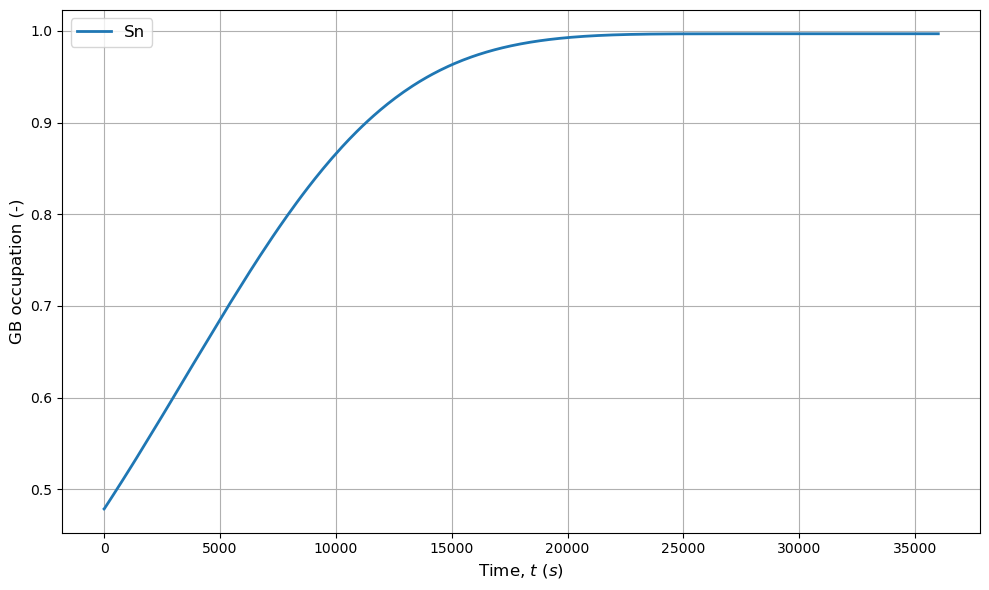

In [450]:
plt.figure(figsize=(10,6))
plt.xlabel("Time, $t$ ($s$)", fontsize=12)
plt.ylabel("GB occupation (-)", fontsize=12)
plt.plot(first_run[0], lw=2, label="Sn")
plt.legend(fontsize=12)
plt.xticks()
plt.grid()
plt.tight_layout()

However, we still do not know which part of the code consumes the most of the time!

To investigate this further, different profiling tools can be used. Python offers buil-in methods like `cProfile` and `profile`. Both are the same and should produce the same output. The difference is, that `cProfile` is a C extension, while `profile` is pure python. Also, `profile` comes with significantly more overhead than the other.  

In [3]:
import cProfile
import profile

In [275]:
# System dependent data
A = 4.0149523035772177*6.9541013797614433/100 # in nm2
GB_thickness = 8.4e-10 # m 

# initialize starting values for concentrations, take from McLean
x_bulk = 0.0004942285667828602
x_hat_start = 0.47854028493419043
E = e_sn

cProfile.run("simple_model(run_time=3600, dt=0.1, accuracy=1e-6, T0=2000, Temb=500, R_G=100e-6, Q_A=sn_q, D0=sn_do, x_bulk=x_bulk, GB_thickness=GB_thickness, E=E, A=A, gb_conc=x_hat_start)")

Cooling speed = 1500.0 C/h
1.2059113883284282e-05
x_global = 0.0005062752262108795
         42989547 function calls in 126.118 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    36001    0.062    0.000    0.062    0.000 3011628812.py:14(linear_heat_treatment)
        1    0.000    0.000    0.000    0.000 3011628812.py:23(gb_site_fraction)
    36001    0.172    0.000    0.172    0.000 3011628812.py:8(diff_coef)
        1    3.711    3.711  126.105  126.105 525834321.py:1(simple_model)
  1224168   34.918    0.000   45.216    0.000 525834321.py:30(obj_func)
  1224168    0.728    0.000    1.513    0.000 <frozen abc>:117(__instancecheck__)
        1    0.013    0.013  126.118  126.118 <string>:1(<module>)
    36001    0.052    0.000    0.298    0.000 _methods.py:55(_any)
  1260169    4.435    0.000    4.435    0.000 _methods.py:90(_clip)
    36001    0.226    0.000    0.257    0.000 _minimize.py:1019(standardize_constraints)
  

The column headings are:

- `ncalls`: number of calls
- `totime`: total time spent in the given function (excluding time spent in subfunctions)
    - `percall`: `totime`/`ncalls`
- `cumtime`: cummulative time spent in this function and all subfunctions
    - `percall`: `cumime`/`ncalls`
- `filename`: function identification


Of course, `cProfile` has a magic cell command `%prun`, which we can use instead of invoking `cProfile` manually.


In [453]:
%prun simple_model(run_time=3600, dt=0.1, accuracy=1e-6, T0=2000, Temb=500, R_G=100e-6, Q_A=sn_q, D0=sn_do, x_bulk=x_bulk, GB_thickness=GB_thickness, E=E, A=A, gb_conc=x_hat_start)

         42989488 function calls in 58.135 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
  1224168   16.330    0.000   21.068    0.000 2009487786.py:27(obj_func)
    36001   13.744    0.000   54.788    0.002 _optimize.py:760(_minimize_neldermead)
  1224168    3.668    0.000   29.443    0.000 _optimize.py:615(function_wrapper)
  1332171    2.502    0.000    2.502    0.000 {method 'reduce' of 'numpy.ufunc' objects}
  1260169    2.006    0.000    2.006    0.000 _methods.py:90(_clip)
  3312427    1.934    0.000    7.090    0.000 fromnumeric.py:53(_wrapfunc)
        1    1.677    1.677   58.127   58.127 2009487786.py:1(simple_model)
  1224168    1.271    0.000    2.732    0.000 numeric.py:1855(isscalar)
   720087    1.206    0.000    3.402    0.000 fromnumeric.py:71(_wrapreduction)
  1368172    1.019    0.000    1.019    0.000 {method 'take' of 'numpy.ndarray' objects}
  1260169    1.013    0.000    4.656    0.000 fromnumeric.

In [273]:
# System dependent data
A = 4.0149523035772177*6.9541013797614433/100 # in nm2
GB_thickness = 8.4e-10 # m 

# initialize starting values for concentrations, take from McLean
x_bulk = 0.0004942285667828602
x_hat_start = 0.47854028493419043
E = e_sn

%prun simple_model(run_time=3600, dt=0.1, accuracy=1e-6, T0=2000, Temb=500, R_G=100e-6, Q_A=sn_q, D0=sn_do, x_bulk=x_bulk, GB_thickness=GB_thickness, E=E, A=A, gb_conc=x_hat_start)

Cooling speed = 1500.0 C/h
1.2059113883284282e-05
x_global = 0.0005062752262108795
 

         42989547 function calls in 128.087 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
  1224168   35.296    0.000   45.809    0.000 525834321.py:30(obj_func)
    36001   30.466    0.001  120.464    0.003 _optimize.py:760(_minimize_neldermead)
  1224168    8.008    0.000   64.189    0.000 _optimize.py:615(function_wrapper)
  1332171    5.853    0.000    5.853    0.000 {method 'reduce' of 'numpy.ufunc' objects}
  1260169    4.409    0.000    4.409    0.000 _methods.py:90(_clip)
  3312427    4.155    0.000   15.742    0.000 fromnumeric.py:53(_wrapfunc)
        1    3.753    3.753  128.074  128.074 525834321.py:1(simple_model)
  1224168    2.768    0.000    5.972    0.000 numeric.py:1855(isscalar)
   720087    2.675    0.000    7.790    0.000 fromnumeric.py:71(_wrapreduction)
   684086    2.333    0.000    2.333    0.000 {method 'argsort' of 'numpy.ndarray' objects}
  1260169    2.285    0.000   10.343    0.000 fromnumeri

In case you have a longer code and you evtl. run it on a HPC you may want to save the ouput to a file.

In [459]:
import cProfile
from pstats import Stats, SortKey

filename="profiling/stats_original_kinetic_model.stats"

cProfile.run("simple_model(run_time=3600, dt=0.1, accuracy=1e-6, T0=2000, Temb=500, R_G=100e-6, Q_A=sn_q, D0=sn_do, x_bulk=x_bulk, GB_thickness=GB_thickness, E=E, A=A, gb_conc=x_hat_start)", filename)

stats = Stats(filename)

# options
stats.strip_dirs() # strips full path of functions
stats.sort_stats(SortKey.TIME, SortKey.CALLS)
stats.print_stats()

Wed May 22 15:21:55 2024    profiling/stats_original_kinetic_model.stats

         42989488 function calls in 57.824 seconds

   Ordered by: internal time, call count

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
  1224168   16.191    0.000   20.913    0.000 2009487786.py:27(obj_func)
    36001   13.693    0.000   54.476    0.002 _optimize.py:760(_minimize_neldermead)
  1224168    3.645    0.000   29.219    0.000 _optimize.py:615(function_wrapper)
  1332171    2.513    0.000    2.513    0.000 {method 'reduce' of 'numpy.ufunc' objects}
  1260169    1.989    0.000    1.989    0.000 _methods.py:90(_clip)
  3312427    1.915    0.000    7.043    0.000 fromnumeric.py:53(_wrapfunc)
        1    1.666    1.666   57.816   57.816 2009487786.py:1(simple_model)
  1224168    1.258    0.000    2.706    0.000 numeric.py:1855(isscalar)
   720087    1.218    0.000    3.397    0.000 fromnumeric.py:71(_wrapreduction)
  1260169    1.024    0.000    4.647    0.000 fromnumeric.py:

It seems that most of the time is spent with the minimization $\dots$ as expected! 

Breakdown:
1. obj_func:
- The obj_func was called 1,224,168 times.
- Total time spent in this function: 16.330 seconds.
- Cumulative time (including calls made by this function): 21.068 seconds.
36001 13.744 0.000 54.788 0.002 _optimize.py:760(_minimize_neldermead):

2. The minimize function from scipy.optimize was called 36,001 times.
- Total time spent in this function: 13.744 seconds.
- Cumulative time: 54.788 seconds.
- 1224168 3.668 0.000 29.443 0.000 _optimize.py:615(function_wrapper):

3. The function wrapper was called 1,224,168 times.
- Total time spent in this function: 3.668 seconds.
- Cumulative time: 29.443 seconds.

4. Other Lines:
- Other lines like _methods.py:90(_clip) and fromnumeric.py:53(_wrapfunc) are internal NumPy functions used frequently during the computation.

What is the **Function Wrapper**?

In the context of `scipy.optimize`, the function wrapper is an internal mechanism used to call the objective function you provided (obj_func). The wrapper takes care of various tasks such as:

- Handling the input arguments.
- Ensuring that the function is called correctly with the parameters being optimized.
- Potentially managing additional functionality like logging, parameter transformations, or handling constraints.

**Implications for Performance**

The profiling output suggests that a substantial amount of time is spent in the optimization process itself, particularly in the calls to the objective function and the optimization routine (minimize). The function_wrapper is part of this process, contributing to the overall computational overhead.

### Can we get more information?

So far, we saw which functions took how long. But there is also a way to look deeper into the functions and investigate each line of a certain function. For that we use a thirdparty `line_profiler`.

```bash
%%bash
pip install line_profiler
```

In [483]:
%load_ext line_profiler

The line_profiler extension doesn't define how to unload it.


In [471]:
%lprun?

Docstring:
Execute a statement under the line-by-line profiler from the
line_profiler module.

Usage:

    %lprun -f func1 -f func2 <statement>

The given statement (which doesn't require quote marks) is run via the
LineProfiler. Profiling is enabled for the functions specified by the -f
options. The statistics will be shown side-by-side with the code through the
pager once the statement has completed.

Options:

-f <function>: LineProfiler only profiles functions and methods it is told
to profile.  This option tells the profiler about these functions. Multiple
-f options may be used. The argument may be any expression that gives
a Python function or method object. However, one must be careful to avoid
spaces that may confuse the option parser.

-m <module>: Get all the functions/methods in a module

One or more -f or -m options are required to get any useful results.

-D <filename>: dump the raw statistics out to a pickle file on disk. The
usual extension for this is ".lprof". These s

In [482]:
%lprun simple_model(run_time=3600, dt=0.1, accuracy=1e-6, T0=2000, Temb=500, R_G=100e-6, Q_A=sn_q, D0=sn_do, x_bulk=x_bulk, GB_thickness=GB_thickness, E=E, A=A, gb_conc=x_hat_start)

Timer unit: 1e-09 s

## Optimization of python code

- Where can we speed up the code:
    - As shown above, most of the time is spent with the minimization, scipy wrapper, and obj_function!
- But, lets try first to all of the np.append functions:

**Making numpy arrays in a loop**
1. Using np.append(not recommended ...):

    - This function does not append to a given array. Instead it creates a new array with the results appended each time. This is both **memory** and **computationally inefficient**. Especially, if we know the resulting array size appriori.

2. Using pre-allocation:

    - This is the most computationally efficient way, but it only works if we know in advance how big the finall array will be.

3. Using a list then convert to numpy array: 

    - If we dont know the final size, it is more efficient if we append to a list and then convert the final result to a numpy array.

```python
def simple_model(run_time: int, dt: float, accuracy: float, T0: float, Temb: float, R_G: float, Q_A: float, D0: float,
                  x_bulk: float, GB_thickness: float, E: float, A: float, gb_conc: float):
    
    
    R_g = (8.314 / (1.602 * 10 ** (-19))) / (6.022 * 10 ** (23))  # gas constant in eV/K --> Boltzmann constant

    # Initializing empty list for saving the results -> We know the final size of these variable: run_time/dt
    Ts = list()
    gb_concs = list()
    ife = list()
    times = list()

    # Model specific parameters
    m = 1
    N_tot = 1
    f = gb_site_fraction(R_G=R_G, gb_width=GB_thickness) 
    fi = f * m/N_tot
    fg = fi / f 
    x_hat_ki = gb_conc 
    x_global = (1 - f) * x_bulk + fi * x_hat_ki
    x_hat_sum = fi * x_hat_ki
    x_bulk_start = x_bulk 


    # Starting value for optimization
    lamda = 0.001

    def obj_func(lamda, Rg_T, x_hat_sum):
        
        nom = np.exp( -(E - lamda) / Rg_T)
        nom = np.clip(nom, a_min=None, a_max=1e300)  

        denom = 1 + np.exp( -(E - lamda) / Rg_T)

        xk_i_hat_temp = nom/denom 
        xk_hat_temp = fi * xk_i_hat_temp 

        
        abs_difference = np.abs(xk_hat_temp - x_hat_sum) 
        return abs_difference
    
    
    options = {'disp': False, 'xatol': accuracy}


    t = 0
    while t < int(run_time):

        # Calculate current temperature -> we can calculate the temperatures even before the main loop
        T = linear_heat_treatment(T0=T0, t_tot=run_time, Tend=Temb, t=t)

        Ts.append(T)
        Rg_T = R_g*T

        # Calculate current diffusion coefficient -> we can calculate the diffusion coefficients even before the main loop
        D = diff_coef(D0=D0, dQ=Q_A, T=T)

        # Perform minimization
        result_value = 1
        rv_i = 0
        while abs(result_value) > accuracy: 
            # Optimization using Nelder-Mead algorithm
            result = minimize(obj_func, lamda, args=(Rg_T, x_hat_sum), method="Nelder-Mead", options=options)
            new_lamda = result.x
            lamda = new_lamda
            result_value = result.fun
            rv_i += 1
            if rv_i > 10: # for checking, 10 is guessed
                print(result_value)
                break
        
        
        nom = np.exp( -(E - lamda) / Rg_T)
        nom = np.clip(nom, a_min=None, a_max=1e300)  

        denom = 1 + np.exp( -(E - lamda) / Rg_T)

        x_hat_ki = nom/denom
        
        #### lets try to remove all append statements as well and just write the results to the initialized np.arrays
        gb_concs.append(x_hat_ki * fg) # questionabel if with fg or not, most likely not
        
        

        nom_ln = 1 - x_bulk
        denom_ln = x_bulk
        frac_ln = np.log(nom_ln/denom_ln)

        lamda_frac = lamda/Rg_T

        lhs = 15*x_bulk*D/(R_G**2)

        dx_hat = (-frac_ln - lamda_frac) * lhs 

        if np.isnan(dx_hat).any():
                    raise ValueError("NaN value encountered in rhs. Stopping calculation.")

        x_hat_sum = x_hat_sum + dx_hat * dt
    
        
        x_bulk = (x_global - x_hat_sum) / (1-f)

        ######### here as well
        ife.append((x_hat_sum * fg - x_bulk_start)/A)

        ######## here as well
        times.append(t)
        t = t + dt

    return gb_concs, ife, Ts, times

### Temperature and diffusion

In [595]:
def isothermal(Tstart: float, t_tot: int, dt: float) -> np.ndarray:
    t_steps = np.arange(0, t_tot + dt, dt)
    return np.full_like(t_steps, Tstart, dtype=np.float32)
    
def linear_heat_treatment(Tstart: float, Tend: float, t_tot: int, dt: float) -> np.ndarray:
    t_steps = np.arange(0, t_tot + dt, dt)
    k = (Tend - Tstart) / t_tot
    temperatures = k * t_steps + Tstart
    return temperatures

def newton_cooling(Tstart: float, Tend: float, t_tot: int, dt: float, r: float) -> np.ndarray:
    t_steps = np.arange(0, t_tot + dt, dt)
    temperatures = Tend + (Tstart - Tend) * np.exp(-r * t_steps**0.5)
    return temperatures

def diff_coef(D0: float, dQ: float, T: np.ndarray, kB: float = (8.314 / (1.602 * 10**(-19))) / (6.022 * 10**(23))) -> np.ndarray:
    diffusion_coefficients = D0 * np.exp(-dQ / (kB * T))
    return diffusion_coefficients

#######################################################################
def get_T_and_D(t_tot: int, Tstart: float, D0: float, dQ: float, Tend: float = None, heat_treatment_type: str = "iso", dt: float = None, r: float = None) -> Tuple[np.ndarray, np.ndarray]:
    if heat_treatment_type == "iso":
        temperatures = isothermal(Tstart=Tstart, t_tot=t_tot, dt=dt)
    elif heat_treatment_type == "linear":
        temperatures = linear_heat_treatment(Tstart=Tstart, Tend=Tend, t_tot=t_tot, dt=dt)
    elif heat_treatment_type == "newton_cooling":
        temperatures = newton_cooling(Tstart=Tstart, Tend=Tend, t_tot=t_tot, dt=dt, r=r)
    else:
        raise ValueError("Invalid heat_treatment_type. Must be 'iso', 'linear', or 'newton_cooling'.")

    diffusion_coefficients = diff_coef(D0=D0, dQ=dQ, T=temperatures)
    return temperatures, diffusion_coefficients

In [599]:
def modified_model_py(t_tot: int, dt: float, accuracy: float, Tstart: float, R_G: float, D0: float, dQ: float,
                  x_bulk: float, GB_thickness: float, E: float, A: float, gb_conc: float, Tend=None, r=None, heat_treatment_type="iso"):
    
    
    R_g = (8.314 / (1.602 * 10 ** (-19))) / (6.022 * 10 ** (23))  # gas constant in eV/K --> Boltzmann constant

    temperatures, diffusion_coefficients = get_T_and_D(t_tot=t_tot, Tstart=Tstart, D0=D0, dQ=dQ, Tend=Tend, 
                                                        heat_treatment_type = heat_treatment_type, dt=dt, r=None)
    Rg_Ts = temperatures * R_g

    
    # Initializing empty np.arrays for the results ->
    # However, this time we are not appending the results but replacing the values inside
    # an np.array with predefined size 
    gb_concs = np.empty(shape=(len(temperatures), 1), dtype=np.float32)
    ife = np.empty(shape=(len(temperatures), 1), dtype=np.float32)
    
    # Model specific parameters
    m = 1
    N_tot = 1
    f = gb_site_fraction(R_G=R_G, gb_width=GB_thickness) 
    fi = f * m/N_tot
    fg = fi / f 
    x_hat_ki = gb_conc 
    x_global = (1 - f) * x_bulk + fi * x_hat_ki
    x_hat_sum = fi * x_hat_ki
    x_bulk_start = x_bulk 


    # Starting value for optimization
    lamda = 0.001

    def obj_func(lamda, Rg_T, x_hat_sum):
        
        nom = np.exp( -(E - lamda) / Rg_T)
        nom = np.clip(nom, a_min=None, a_max=1e300)  

        denom = 1 + np.exp( -(E - lamda) / Rg_T)

        xk_i_hat_temp = nom/denom 
        xk_hat_temp = fi * xk_i_hat_temp 

        
        abs_difference = np.abs(xk_hat_temp - x_hat_sum) 
        return abs_difference
    
    
    options = {'disp': False, 'xatol': accuracy}


    for indx in range(len(temperatures)):

        # Calculate current temperature -> we can calculate the temperatures even before the main loop
        #T = linear_heat_treatment(T0=T0, t_tot=run_time, Tend=Temb, t=t)
        
        #Ts.append(T) # now we can remove it
        #Rg_T = R_g*T # we can remove this as well
        Rg_T = Rg_Ts[indx]
        
        # Calculate current diffusion coefficient -> we can calculate the diffusion coefficients even before the main loop
        #D = diff_coef(D0=D0, dQ=Q_A, T=T)
        D = diffusion_coefficients[indx]
        
        # Perform minimization
        result_value = 1
        rv_i = 0
        while abs(result_value) > accuracy: 
            # Optimization using Nelder-Mead algorithm
            result = minimize(obj_func, lamda, args=(Rg_T, x_hat_sum), method="Nelder-Mead", options=options)
            new_lamda = result.x
            lamda = new_lamda
            result_value = result.fun
            rv_i += 1
            if rv_i > 10: # for checking, 10 is guessed
                print(result_value)
                break
        
        
        nom = np.exp( -(E - lamda) / Rg_T)
        nom = np.clip(nom, a_min=None, a_max=1e300)  

        denom = 1 + np.exp( -(E - lamda) / Rg_T)

        x_hat_ki = nom/denom
        
        #### lets try to remove all append statements as well and just write the results to the initialized np.arrays
        #gb_concs.append(x_hat_ki * fg) # questionabel if with fg or not, most likely not
        # we can now change the value of the array at the indx
        gb_concs[indx] = x_hat_ki * fg
        

        nom_ln = 1 - x_bulk
        denom_ln = x_bulk
        frac_ln = np.log(nom_ln/denom_ln)

        lamda_frac = lamda/Rg_T

        lhs = 15*x_bulk*D/(R_G**2)

        dx_hat = (-frac_ln - lamda_frac) * lhs 

        if np.isnan(dx_hat).any():
                    raise ValueError("NaN value encountered in rhs. Stopping calculation.")

        x_hat_sum = x_hat_sum + dx_hat * dt
    
        
        x_bulk = (x_global - x_hat_sum) / (1-f)

        ######### we can now simply change the values in the predefined arrays
        #ife.append((x_hat_sum * fg - x_bulk_start)/A)
        ife[indx] = (x_hat_sum * fg - x_bulk_start)/A
        
        ######## We dont need to update the times any more
        #times.append(t)
        #t = t + dt
    return gb_concs, ife

In [602]:
%%timeit -r 3
# System dependent data
A = 4.0149523035772177*6.9541013797614433/100 # in nm2
GB_thickness = 8.4e-10 # m 

# initialize starting values for concentrations, take from McLean
x_bulk = 0.0004942285667828602
x_hat_start = 0.47854028493419043
E = e_sn

 
results_modified_model_py = modified_model_py(t_tot=3600, dt=0.1, accuracy=1e-6, Tstart=2000, R_G=100e-6, dQ=sn_q, D0=sn_do, x_bulk=x_bulk,
                        GB_thickness=GB_thickness, E=E, A=A, gb_conc=x_hat_start, Tend=500, heat_treatment_type="linear")

1min 11s ± 6.76 s per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [ ]:
Now that we used pre-allocation instead of append functions, we made it at least more memory efficient. In this example we do not really observe time savings, since the minimize function takes the most time. However, thinking of heavier problems with more solutes and sites and longer simulation times (hence more appends) this code corrections might also pay of with respect to computational time (and especially with repect to memory!) 

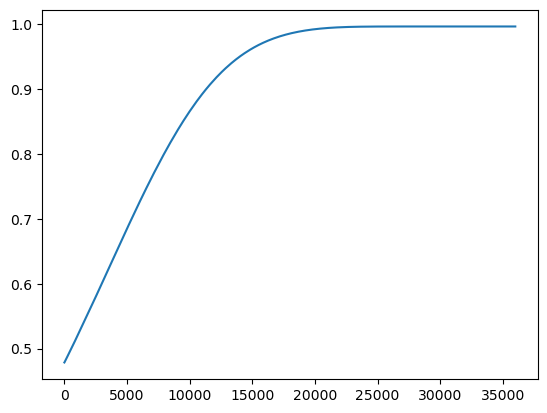

In [603]:
plt.plot(results_modified_model_py[0])

## Cython

Python is a very flexible and easy to lear programming language. It also has a lot of modules and functions which can be easily integrated. However, it is a dynamically typed language. This means that each time we run a code, the code is checked and exectuted simultaneously. This makes the code slower. In contrast, languages like C are statically typed languages and hence, the code needs to be pre-compiled. This makes the actual execution much faster. However, the language is much harder than python. Cython is a package which translates python code into C code, and in some situations can provide significant boost ups. 

### Step 1: Create Cython source file

Save the source file with the magic command `%%writefile`. Cython source files need the .pyx extension.

#### Pure python

In [70]:
%%writefile ./examples/cython/heat_treatment.py
from typing import List, Tuple, Dict
import numpy as np

def isothermal(Tstart: float, t_tot: int, dt: float) -> np.ndarray:
    t_steps = np.arange(0, t_tot + dt, dt)
    return np.full_like(t_steps, Tstart, dtype=np.float32)
    
def linear_heat_treatment(Tstart: float, Tend: float, t_tot: int, dt: float) -> np.ndarray:
    t_steps = np.arange(0, t_tot + dt, dt)
    k = (Tend - Tstart) / t_tot
    temperatures = k * t_steps + Tstart
    return temperatures

def newton_cooling(Tstart: float, Tend: float, t_tot: int, dt: float, r: float) -> np.ndarray:
    t_steps = np.arange(0, t_tot + dt, dt)
    temperatures = Tend + (Tstart - Tend) * np.exp(-r * t_steps**0.5)
    return temperatures

def diff_coef(D0: float, dQ: float, T: np.ndarray, kB: float = (8.314 / (1.602 * 10**(-19))) / (6.022 * 10**(23))) -> np.ndarray:
    diffusion_coefficients = D0 * np.exp(-dQ / (kB * T))
    return diffusion_coefficients

#######################################################################
def get_T_and_D(t_tot: int, Tstart: float, D0: float, dQ: float, Tend: float = None, heat_treatment_type: str = "iso", dt: float = None, r: float = None) -> Tuple[np.ndarray, np.ndarray]:
    if heat_treatment_type == "iso":
        temperatures = isothermal(Tstart=Tstart, t_tot=t_tot, dt=dt)
    elif heat_treatment_type == "linear":
        temperatures = linear_heat_treatment(Tstart=Tstart, Tend=Tend, t_tot=t_tot, dt=dt)
    elif heat_treatment_type == "newton_cooling":
        temperatures = newton_cooling(Tstart=Tstart, Tend=Tend, t_tot=t_tot, dt=dt, r=r)
    else:
        raise ValueError("Invalid heat_treatment_type. Must be 'iso', 'linear', or 'newton_cooling'.")

    diffusion_coefficients = diff_coef(D0=D0, dQ=dQ, T=temperatures)
    return temperatures, diffusion_coefficients

Overwriting ./examples/cython/heat_treatment.py


#### Annotated

Without changing anything in the code, we can "cythonize" the given function. In order to do so we need to create a file with .pyx extension. We need to compile this function later with the help of a setup file and import back into python.

In [56]:
%%writefile ./examples/cython/heat_treatment_annotated.pyx
import numpy as np

def isothermal(Tstart: float, t_tot: int, dt: float) -> np.ndarray:
    t_steps = np.arange(0, t_tot + dt, dt)
    return np.full_like(t_steps, Tstart, dtype=np.float32)
    
def linear_heat_treatment(Tstart: float, Tend: float, t_tot: int, dt: float) -> np.ndarray:
    t_steps = np.arange(0, t_tot + dt, dt)
    k = (Tend - Tstart) / t_tot
    temperatures = k * t_steps + Tstart
    return temperatures

def newton_cooling(Tstart: float, Tend: float, t_tot: int, dt: float, r: float) -> np.ndarray:
    t_steps = np.arange(0, t_tot + dt, dt)
    temperatures = Tend + (Tstart - Tend) * np.exp(-r * t_steps**0.5)
    return temperatures

def diff_coef(D0: float, dQ: float, T: np.ndarray, kB: float = (8.314 / (1.602 * 10**(-19))) / (6.022 * 10**(23))) -> np.ndarray:
    diffusion_coefficients = D0 * np.exp(-dQ / (kB * T))
    return diffusion_coefficients

#######################################################################
def get_T_and_D(t_tot: int, Tstart: float, D0: float, dQ: float, Tend: float = None, heat_treatment_type: str = "iso", dt: float = None, r: float = None) -> Tuple[np.ndarray, np.ndarray]:
    if heat_treatment_type == "iso":
        temperatures = isothermal(Tstart=Tstart, t_tot=t_tot, dt=dt)
    elif heat_treatment_type == "linear":
        temperatures = linear_heat_treatment(Tstart=Tstart, Tend=Tend, t_tot=t_tot, dt=dt)
    elif heat_treatment_type == "newton_cooling":
        temperatures = newton_cooling(Tstart=Tstart, Tend=Tend, t_tot=t_tot, dt=dt, r=r)
    else:
        raise ValueError("Invalid heat_treatment_type. Must be 'iso', 'linear', or 'newton_cooling'.")

    diffusion_coefficients = diff_coef(D0=D0, dQ=dQ, T=temperatures)
    return temperatures, diffusion_coefficients

Overwriting ./examples/cython/heat_treatment_annotated.pyx


There is the option to have a look at how much cython needs to interact with the Python virtual machine. Wieth the command line code below, we create an annotated file in HTML, which can be opened and analyzed in the browser tab. The more yellow a line is, the more Python interaction there is. Our goal is to reduce Python interactions as much as possible.

In [57]:
!cython -a ./examples/cython/heat_treatment_annotated.pyx

/home/amin/anaconda3/envs/pycalphad/lib/python3.11/site-packages/Cython/Compiler/Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /home/amin/projects/gb_thermodynamics/mclean/examples/cython/heat_treatment_annotated.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


#### Cythonized

In [62]:
%%writefile ./examples/cython/heat_treatment_cythonized.pyx
import numpy as np
cimport numpy as np  # Cython-specific import for type declarations
from libc.math cimport exp, sqrt

# Function declarations
cdef float[:] isothermal(float Tstart, int t_tot, float dt):
    cdef int n = int(t_tot / dt) + 1
    cdef float[:] t_steps = np.zeros(n, dtype=np.float32)
    cdef float[:] temperatures = np.zeros(n, dtype=np.float32)
    cdef int i
    for i in range(n):
        t_steps[i] = i * dt
        temperatures[i] = Tstart
    return temperatures

cdef float[:] linear_heat_treatment(float Tstart, float Tend, int t_tot, float dt):
    cdef int n = int(t_tot / dt) + 1
    cdef float[:] t_steps = np.zeros(n, dtype=np.float32)
    cdef float[:] temperatures = np.zeros(n, dtype=np.float32)
    cdef float k = (Tend - Tstart) / t_tot
    cdef int i
    for i in range(n):
        t_steps[i] = i * dt
        temperatures[i] = k * t_steps[i] + Tstart
    return temperatures

cdef float[:] newton_cooling(float Tstart, float Tend, int t_tot, float dt, float r):
    cdef int n = int(t_tot / dt) + 1
    cdef float[:] t_steps = np.zeros(n, dtype=np.float32)
    cdef float[:] temperatures = np.zeros(n, dtype=np.float32)
    cdef int i
    for i in range(n):
        t_steps[i] = i * dt
        temperatures[i] = Tend + (Tstart - Tend) * exp(-r * sqrt(t_steps[i]))
    return temperatures

cdef float[:] diff_coef(float D0, float dQ, float[:] T, float kB):
    cdef int n = T.shape[0]
    cdef float[:] diffusion_coefficients = np.zeros(n, dtype=np.float32)
    cdef int i
    for i in range(n):
        diffusion_coefficients[i] = D0 * exp(-dQ / (kB * T[i]))
    return diffusion_coefficients

# Main function
cpdef tuple get_T_and_D(int t_tot, float Tstart, float D0, float dQ, float dt, float Tend=-1, str heat_treatment_type="iso", float r=-1):
    cdef float[:] temperatures
    cdef float[:] diffusion_coefficients
    if heat_treatment_type == "iso":
        temperatures = isothermal(Tstart=Tstart, t_tot=t_tot, dt=dt)
    elif heat_treatment_type == "linear":
        if Tend == -1:
            raise ValueError("Tend must be provided for linear heat treatment.")
        temperatures = linear_heat_treatment(Tstart=Tstart, Tend=Tend, t_tot=t_tot, dt=dt)
    elif heat_treatment_type == "newton_cooling":
        if Tend == -1 or r == -1:
            raise ValueError("Tend and r must be provided for Newton cooling heat treatment.")
        temperatures = newton_cooling(Tstart=Tstart, Tend=Tend, t_tot=t_tot, dt=dt, r=r)
    else:
        raise ValueError("Invalid heat_treatment_type. Must be 'iso', 'linear', or 'newton_cooling'.")

    diffusion_coefficients = diff_coef(D0=D0, dQ=dQ, T=temperatures, kB=(8.314 / (1.602 * 10**(-19))) / (6.022 * 10**(23)))
    return temperatures, diffusion_coefficients


Writing ./examples/cython/heat_treatment_cythonized.pyx


In [63]:
!cython -a ./examples/cython/heat_treatment_cythonized.pyx

/home/amin/anaconda3/envs/pycalphad/lib/python3.11/site-packages/Cython/Compiler/Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /home/amin/projects/gb_thermodynamics/mclean/examples/cython/heat_treatment_cythonized.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


### Step 2: Create a setup file

Create a setup.py file for buildung the Cython extension module.

In [91]:
%%writefile ./examples/cython/setup_heat_treatment.py
from Cython.Build import cythonize
from setuptools import setup, Extension
import numpy as np

extensions = [
    Extension(
        "heat_treatment_annotated",
        ["./examples/cython/heat_treatment_annotated.pyx"],
        include_dirs=[np.get_include()],  # Include the NumPy headers
    ),
    Extension(
        "heat_treatment_cythonized",
        ["./examples/cython/heat_treatment_cythonized.pyx"],
        include_dirs=[np.get_include()],  # Include the NumPy headers
    )
]

setup(
    ext_modules=cythonize(
        extensions,
        compiler_directives={'language_level': "3"}  # Ensure Cython uses Python 3 syntax
    ),
)

Overwriting ./examples/cython/setup_heat_treatment.py


### Step 3: Compile the code

In [92]:
!python3 ./examples/cython/setup_heat_treatment.py build_ext -b ./examples/cython

running build_ext
building 'heat_treatment_annotated' extension
gcc -pthread -B /home/amin/anaconda3/envs/pycalphad/compiler_compat -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/amin/anaconda3/envs/pycalphad/include -fPIC -O2 -isystem /home/amin/anaconda3/envs/pycalphad/include -fPIC -I/home/amin/anaconda3/envs/pycalphad/lib/python3.11/site-packages/numpy/core/include -I/home/amin/anaconda3/envs/pycalphad/include/python3.11 -c ./examples/cython/heat_treatment_annotated.c -o build/temp.linux-x86_64-cpython-311/./examples/cython/heat_treatment_annotated.o
gcc -pthread -B /home/amin/anaconda3/envs/pycalphad/compiler_compat -shared -Wl,--allow-shlib-undefined -Wl,-rpath,/home/amin/anaconda3/envs/pycalphad/lib -Wl,-rpath-link,/home/amin/anaconda3/envs/pycalphad/lib -L/home/amin/anaconda3/envs/pycalphad/lib -Wl,--allow-shlib-undefined -Wl,-rpath,/home/amin/anaconda3/envs/pycalphad/lib -Wl,-rpath-link,/home/amin/anaconda3/envs/pycalphad/lib -L/home/amin/anaconda3/envs/pycalphad/lib buil

### Step 4: Benchmarking

In [99]:
%%writefile ./examples/cython/execute_heat_treatments.py
from timeit import timeit

# Benchmark the get_T_and_D function
t1 = timeit("get_T_and_D(t_tot=1000, Tstart=1000, D0=0.5, dQ=1.9e-9, Tend=100, dt=0.1, heat_treatment_type='linear', r=-1)",
            setup="from heat_treatment import get_T_and_D",
            number=10000)

# Benchmark the get_T_and_D function
t2 = timeit("get_T_and_D(t_tot=1000, Tstart=1000, D0=0.5, dQ=1.9e-9, Tend=100.0, dt=0.1, heat_treatment_type='linear', r=-1.0)",
            setup="from heat_treatment_annotated import get_T_and_D",
            number=10000)

t3 = timeit("get_T_and_D(1000, 1000.0, 0.5, 1e-9, 1.0, 100.0, 'linear', -1.0)",
            setup="from heat_treatment_cythonized import get_T_and_D",
            number=10000)

print(f"Python: Time for get_T_and_D: {t1} seconds for 10k runs")
print(f"Annotated: Time for get_T_and_D is {t1/t2} times faster than python for 10k runs")
print(f"Cythonized: Time for get_T_and_D is {t1/t3} times faster than python for 10k runs")


Overwriting ./examples/cython/execute_heat_treatments.py


In [100]:
!python3 ./examples/cython/execute_heat_treatments.py

Python: Time for get_T_and_D: 0.3917671650015109 seconds for 10k runs
Annotated: Time for get_T_and_D is 1.1146550308678274 times faster than python for 10k runs
Cythonized: Time for get_T_and_D is 3.154767327863118 times faster than python for 10k runs


Good, we see that for this example, the time we gained is marginally and basically we can leave our pure python code as it is. Reason is, that the pure python code uses anyway only numpy which is written in C. However, we still could make the code faster.

So how much improvement can we get if we cythonize the kinetic model?

# Optimization of kinetic model

## Pure python

In [133]:
%%writefile ./examples/cython/kinetics_python.py 

import numpy as np
from scipy.optimize import minimize
from heat_treatment import get_T_and_D

# Calculate fraction of GB sites compared to all sites in the system
def gb_site_fraction(R_G=100e-6, gb_width=8.4e-10):
    V_G = R_G**3
    V_GB = V_G - (R_G - gb_width)**3
    return V_GB/V_G

def kinetics_python(t_tot: int, dt: float, accuracy: float, Tstart: float, R_G: float, D0: float, dQ: float,
                  x_bulk: float, GB_thickness: float, E: float, A: float, gb_conc: float, Tend=None, r=None, heat_treatment_type="linear"):
    
    
    R_g = (8.314 / (1.602 * 10 ** (-19))) / (6.022 * 10 ** (23))  # gas constant in eV/K --> Boltzmann constant

    temperatures, diffusion_coefficients = get_T_and_D(t_tot=t_tot, Tstart=Tstart, D0=D0, dQ=dQ, dt=dt, Tend=Tend, heat_treatment_type=heat_treatment_type, r=r)
    Rg_Ts = temperatures * R_g

    gb_concs = np.empty(shape=(len(temperatures), 1), dtype=np.float32)
    ife = np.empty(shape=(len(temperatures), 1), dtype=np.float32)
    
    # Model specific parameters
    m = 1
    N_tot = 1
    f = gb_site_fraction(R_G=R_G, gb_width=GB_thickness) 
    fi = f * m/N_tot
    fg = fi / f 
    x_hat_ki = gb_conc 
    x_global = (1 - f) * x_bulk + fi * x_hat_ki
    x_hat_sum = fi * x_hat_ki
    x_bulk_start = x_bulk 


    # Starting value for optimization
    lamda = 0.001

    def obj_func(lamda, Rg_T, x_hat_sum):
        
        nom = np.exp( -(E - lamda) / Rg_T)
        nom = np.clip(nom, a_min=None, a_max=1e300)  

        denom = 1 + np.exp( -(E - lamda) / Rg_T)

        xk_i_hat_temp = nom/denom 
        xk_hat_temp = fi * xk_i_hat_temp 

        
        abs_difference = np.abs(xk_hat_temp - x_hat_sum) 
        return abs_difference
    
    
    options = {'disp': False, 'xatol': accuracy}


    for indx in range(len(temperatures)):

        Rg_T = Rg_Ts[indx]
        
        D = diffusion_coefficients[indx]
        
        # Perform minimization
        result_value = 1
        rv_i = 0
        while abs(result_value) > accuracy: 
            # Optimization using Nelder-Mead algorithm
            result = minimize(obj_func, lamda, args=(Rg_T, x_hat_sum), method="Nelder-Mead", options=options)
            new_lamda = result.x
            lamda = new_lamda
            result_value = result.fun
            rv_i += 1
            if rv_i > 10: # for checking, 10 is guessed
                print(result_value)
                break
        
        
        nom = np.exp( -(E - lamda) / Rg_T)
        nom = np.clip(nom, a_min=None, a_max=1e300)  

        denom = 1 + np.exp( -(E - lamda) / Rg_T)

        x_hat_ki = nom/denom
        
        gb_concs[indx] = x_hat_ki * fg
        

        nom_ln = 1 - x_bulk
        denom_ln = x_bulk
        frac_ln = np.log(nom_ln/denom_ln)

        lamda_frac = lamda/Rg_T

        lhs = 15*x_bulk*D/(R_G**2)

        dx_hat = (-frac_ln - lamda_frac) * lhs 

        if np.isnan(dx_hat).any():
                    raise ValueError("NaN value encountered in rhs. Stopping calculation.")

        x_hat_sum = x_hat_sum + dx_hat * dt
    
        
        x_bulk = (x_global - x_hat_sum) / (1-f)

        ife[indx] = (x_hat_sum * fg - x_bulk_start)/A
        
    return gb_concs, ife

Overwriting ./examples/cython/kinetics_python.py


## Annotated

In [240]:
%%writefile ./examples/cython/kinetics_annotated.pyx 

import numpy as np
from scipy.optimize import minimize
from heat_treatment_annotated import get_T_and_D

# Calculate fraction of GB sites compared to all sites in the system
def gb_site_fraction(R_G=100e-6, gb_width=8.4e-10):
    V_G = R_G**3
    V_GB = V_G - (R_G - gb_width)**3
    return V_GB/V_G

def kinetics_annotated(t_tot: int, dt: float, accuracy: float, Tstart: float, R_G: float, D0: float, dQ: float,
                  x_bulk: float, GB_thickness: float, E: float, A: float, gb_conc: float, Tend=None, r=None, heat_treatment_type="linear"):
    
    
    R_g = (8.314 / (1.602 * 10 ** (-19))) / (6.022 * 10 ** (23))  # gas constant in eV/K --> Boltzmann constant
    
    temperatures, diffusion_coefficients = get_T_and_D(t_tot=t_tot, Tstart=Tstart, D0=D0, dQ=dQ, dt=dt, Tend=Tend, heat_treatment_type=heat_treatment_type, r=r)
    Rg_Ts = temperatures * R_g

    gb_concs = np.empty(shape=(len(temperatures), 1), dtype=np.float32)
    ife = np.empty(shape=(len(temperatures), 1), dtype=np.float32)
    
    # Model specific parameters
    m = 1
    N_tot = 1
    f = gb_site_fraction(R_G=R_G, gb_width=GB_thickness) 
    fi = f * m/N_tot
    fg = fi / f 
    x_hat_ki = gb_conc 
    x_global = (1 - f) * x_bulk + fi * x_hat_ki
    x_hat_sum = fi * x_hat_ki
    x_bulk_start = x_bulk 


    # Starting value for optimization
    lamda = 0.001

    def obj_func(lamda, Rg_T, x_hat_sum):
        
        nom = np.exp( -(E - lamda) / Rg_T)
        nom = np.clip(nom, a_min=None, a_max=1e300)  

        denom = 1 + np.exp( -(E - lamda) / Rg_T)

        xk_i_hat_temp = nom/denom 
        xk_hat_temp = fi * xk_i_hat_temp 

        
        abs_difference = np.abs(xk_hat_temp - x_hat_sum) 
        return abs_difference
    
    
    options = {'disp': False, 'xatol': accuracy}


    for indx in range(len(temperatures)):

        Rg_T = Rg_Ts[indx]
        
        D = diffusion_coefficients[indx]
        
        # Perform minimization
        result_value = 1
        rv_i = 0
        while abs(result_value) > accuracy: 
            # Optimization using Nelder-Mead algorithm
            result = minimize(obj_func, lamda, args=(Rg_T, x_hat_sum), method="Nelder-Mead", options=options)
            new_lamda = result.x
            lamda = new_lamda
            result_value = result.fun
            rv_i += 1
            if rv_i > 10: # for checking, 10 is guessed
                print(result_value)
                break
        
        
        nom = np.exp( -(E - lamda) / Rg_T)
        nom = np.clip(nom, a_min=None, a_max=1e300)  

        denom = 1 + np.exp( -(E - lamda) / Rg_T)

        x_hat_ki = nom/denom
        
        gb_concs[indx] = x_hat_ki * fg
        

        nom_ln = 1 - x_bulk
        denom_ln = x_bulk
        frac_ln = np.log(nom_ln/denom_ln)

        lamda_frac = lamda/Rg_T

        lhs = 15*x_bulk*D/(R_G**2)

        dx_hat = (-frac_ln - lamda_frac) * lhs 

        if np.isnan(dx_hat).any():
                    raise ValueError("NaN value encountered in rhs. Stopping calculation.")

        x_hat_sum = x_hat_sum + dx_hat * dt
    
        
        x_bulk = (x_global - x_hat_sum) / (1-f)

        ife[indx] = (x_hat_sum * fg - x_bulk_start)/A
        
    return gb_concs, ife

Overwriting ./examples/cython/kinetics_annotated.pyx


## Cythonized

In [241]:
%%writefile ./examples/cython/kinetics_cythonized.pyx 

import numpy as np
cimport numpy as np
from scipy.optimize import minimize
from libc.math cimport exp, sqrt

# Function declarations
cdef np.ndarray[np.float32_t, ndim=1] isothermal(float Tstart, int t_tot, float dt):
    cdef int n = int(t_tot / dt) + 1
    cdef np.ndarray[np.float32_t, ndim=1] t_steps = np.zeros(n, dtype=np.float32)
    cdef np.ndarray[np.float32_t, ndim=1] temperatures = np.zeros(n, dtype=np.float32)
    cdef int i
    for i in range(n):
        t_steps[i] = i * dt
        temperatures[i] = Tstart
    return temperatures


cdef np.ndarray[np.float32_t, ndim=1] linear_heat_treatment(float Tstart, float Tend, int t_tot, float dt):
    cdef int n = int(t_tot / dt) + 1
    cdef np.ndarray[np.float32_t, ndim=1] t_steps = np.zeros(n, dtype=np.float32)
    cdef np.ndarray[np.float32_t, ndim=1] temperatures = np.zeros(n, dtype=np.float32)
    cdef float k = (Tend - Tstart) / t_tot
    cdef int i
    for i in range(n):
        t_steps[i] = i * dt
        temperatures[i] = k * t_steps[i] + Tstart
    return temperatures

cdef np.ndarray[np.float32_t, ndim=1] newton_cooling(float Tstart, float Tend, int t_tot, float dt, float r):
    cdef int n = int(t_tot / dt) + 1
    cdef np.ndarray[np.float32_t, ndim=1] t_steps = np.zeros(n, dtype=np.float32)
    cdef np.ndarray[np.float32_t, ndim=1] temperatures = np.zeros(n, dtype=np.float32)
    cdef int i
    for i in range(n):
        t_steps[i] = i * dt
        temperatures[i] = Tend + (Tstart - Tend) * exp(-r * sqrt(t_steps[i]))
    return temperatures

cdef np.ndarray[np.float32_t, ndim=1] diff_coef(float D0, float dQ, np.ndarray[np.float32_t, ndim=1] T, float kB):
    cdef int n = T.shape[0]
    cdef np.ndarray[np.float32_t, ndim=1] diffusion_coefficients = np.zeros(n, dtype=np.float32)
    cdef int i
    for i in range(n):
        diffusion_coefficients[i] = D0 * exp(-dQ / (kB * T[i]))
    return diffusion_coefficients

cpdef tuple get_T_and_D(int t_tot, float Tstart, float D0, float dQ, float dt, float Tend=-1, str heat_treatment_type="iso", float r=-1):
    cdef np.ndarray[np.float32_t, ndim=1] temperatures, diffusion_coefficients
    if heat_treatment_type == "iso":
        temperatures = isothermal(Tstart=Tstart, t_tot=t_tot, dt=dt)
    elif heat_treatment_type == "linear":
        if Tend == -1:
            raise ValueError("Tend must be provided for linear heat treatment.")
        temperatures = linear_heat_treatment(Tstart=Tstart, Tend=Tend, t_tot=t_tot, dt=dt)
    elif heat_treatment_type == "newton_cooling":
        if Tend == -1 or r == -1:
            raise ValueError("Tend and r must be provided for Newton cooling heat treatment.")
        temperatures = newton_cooling(Tstart=Tstart, Tend=Tend, t_tot=t_tot, dt=dt, r=r)
    else:
        raise ValueError("Invalid heat_treatment_type. Must be 'iso', 'linear', or 'newton_cooling'.")

    diffusion_coefficients = diff_coef(D0=D0, dQ=dQ, T=temperatures, kB=(8.314 / (1.602 * 10**(-19))) / (6.022 * 10**(23)))

    return temperatures, diffusion_coefficients


# Calculate fraction of GB sites compared to all sites in the system
cdef double gb_site_fraction(double R_G=100e-6, double gb_width=8.4e-10):
    cdef double V_G = R_G**3
    cdef double V_GB = V_G - (R_G - gb_width)**3
    return V_GB / V_G

cdef double obj_func(double lamda, double Rg_T, double x_hat_sum, double fi, double E):
    cdef double nom = np.exp(-(E - lamda) / Rg_T)
    nom = np.clip(nom, a_min=None, a_max=1e300)
    cdef double denom = 1 + np.exp(-(E - lamda) / Rg_T)
    cdef double xk_i_hat_temp = nom / denom
    cdef double xk_hat_temp = fi * xk_i_hat_temp
    return abs(xk_hat_temp - x_hat_sum)

cpdef tuple kinetics_cythonized(int t_tot, double dt, double accuracy, double Tstart, double R_G, double D0, double dQ,
                            double x_bulk, double GB_thickness, double E, double A, double gb_conc, 
                            double Tend=-1, double r=-1, str heat_treatment_type="linear"):
    cdef double R_g = (8.314 / (1.602 * 10 ** (-19))) / (6.022 * 10 ** (23))
    
    cdef np.ndarray[np.float32_t, ndim=1] temperatures, diffusion_coefficients, gb_concs, ife
    temperatures, diffusion_coefficients = get_T_and_D(t_tot, Tstart, D0, dQ, dt, Tend, heat_treatment_type, r)
    
    cdef int len_temp = len(temperatures)
    gb_concs = np.empty(len_temp, dtype=np.float32)
    ife = np.empty(len_temp, dtype=np.float32)
    
    cdef np.ndarray[np.float32_t, ndim=1] Rg_Ts = temperatures * R_g
    cdef np.ndarray[np.float32_t, ndim=1] diff_coefs = diffusion_coefficients
    
    cdef double m = 1
    cdef double N_tot = 1
    cdef double f = gb_site_fraction(R_G, GB_thickness)
    cdef double fi = f * m / N_tot
    cdef double fg = fi / f
    cdef double x_hat_ki = gb_conc
    cdef double x_global = (1 - f) * x_bulk + fi * x_hat_ki
    cdef double x_hat_sum = fi * x_hat_ki
    cdef double x_bulk_start = x_bulk

    cdef double lamda = 0.001

    cdef int indx
    cdef double Rg_T, D, result_value, new_lamda, nom, denom, nom_ln, denom_ln, frac_ln, lamda_frac, lhs, dx_hat

    for indx in range(len_temp):
        Rg_T = Rg_Ts[indx]
        D = diff_coefs[indx]
        
        result_value = 1
        while abs(result_value) > accuracy:
            result = minimize(obj_func, lamda, args=(Rg_T, x_hat_sum, fi, E), method="Nelder-Mead", options={'disp': False, 'xatol': accuracy})
            new_lamda = result.x[0]
            lamda = new_lamda
            result_value = result.fun
            if result_value < accuracy:
                break
        
        nom = exp(-(E - lamda) / Rg_T)
        nom = max(nom, 1e-300)  # Use max instead of np.clip for Cython
        denom = 1 + exp(-(E - lamda) / Rg_T)
        x_hat_ki = nom / denom
        gb_concs[indx] = x_hat_ki * fg

        nom_ln = 1 - x_bulk
        denom_ln = x_bulk
        frac_ln = np.log(nom_ln / denom_ln)
        lamda_frac = lamda / Rg_T
        lhs = 15 * x_bulk * D / (R_G**2)
        dx_hat = (-frac_ln - lamda_frac) * lhs
        
        if np.isnan(dx_hat).any():
            raise ValueError("NaN value encountered in rhs. Stopping calculation.")
        
        x_hat_sum += dx_hat * dt
        x_bulk = (x_global - x_hat_sum) / (1 - f)
        ife[indx] = (x_hat_sum * fg - x_bulk_start) / A
        
    return gb_concs, ife



Overwriting ./examples/cython/kinetics_cythonized.pyx


### Setup file

In [242]:
%%writefile ./examples/cython/setup_kinetics.py
from Cython.Build import cythonize
from setuptools import setup, Extension
import numpy as np

extensions = [
    Extension(
        "kinetics_annotated",
        ["./examples/cython/kinetics_annotated.pyx"],
        include_dirs=[np.get_include()],  # Include the NumPy headers
    ),
    Extension(
        "kinetics_cythonized",
        ["./examples/cython/kinetics_cythonized.pyx"],
        include_dirs=[np.get_include()],  # Include the NumPy headers
    )
]

setup(
    ext_modules=cythonize(
        extensions,
        compiler_directives={'language_level': "3"}  # Ensure Cython uses Python 3 syntax
    ),
)

Overwriting ./examples/cython/setup_kinetics.py


### Compiling

In [243]:
!python3 ./examples/cython/setup_kinetics.py build_ext -b ./examples/cython

Compiling ./examples/cython/kinetics_annotated.pyx because it changed.
Compiling ./examples/cython/kinetics_cythonized.pyx because it changed.
[1/2] Cythonizing ./examples/cython/kinetics_annotated.pyx
[2/2] Cythonizing ./examples/cython/kinetics_cythonized.pyx
running build_ext
building 'kinetics_annotated' extension
gcc -pthread -B /home/amin/anaconda3/envs/pycalphad/compiler_compat -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/amin/anaconda3/envs/pycalphad/include -fPIC -O2 -isystem /home/amin/anaconda3/envs/pycalphad/include -fPIC -I/home/amin/anaconda3/envs/pycalphad/lib/python3.11/site-packages/numpy/core/include -I/home/amin/anaconda3/envs/pycalphad/include/python3.11 -c ./examples/cython/kinetics_annotated.c -o build/temp.linux-x86_64-cpython-311/./examples/cython/kinetics_annotated.o
gcc -pthread -B /home/amin/anaconda3/envs/pycalphad/compiler_compat -shared -Wl,--allow-shlib-undefined -Wl,-rpath,/home/amin/anaconda3/envs/pycalphad/lib -Wl,-rpath-link,/home/amin/anaconda

### Benchmarking

In [245]:
%%writefile ./examples/cython/execute_kinetics.py
from timeit import timeit
import matplotlib.pyplot as plt

# Define the parameters
params = {
    't_tot': 3600,
    'dt': 0.1,
    'accuracy': 1e-6,
    'Tstart': 2000.0,
    'R_G': 100e-6,
    'dQ': 2.355,
    'D0': 3.3e-5,
    'x_bulk': 0.0004942285667828602,
    'GB_thickness': 8.4e-10,
    'E': -1.2972039599999334,
    'A': 0.27920385353982713,
    'gb_conc': 0.47854028493419043,
    'Tend': 500.0,
    'heat_treatment_type': 'linear',
    'r': -1.0
}


t1 = timeit("kinetics_python(**params)",
            setup="from kinetics_python import kinetics_python; from __main__ import params",
            number=1)

t2 = timeit("kinetics_annotated(**params)",
            setup="from kinetics_annotated import kinetics_annotated; from __main__ import params",
            number=1)

t3 = timeit("kinetics_cythonized(**params)",
            setup="from kinetics_cythonized import kinetics_cythonized; from __main__ import params",
            number=1)

print(f"Python: Time for get kinetics: {t1} seconds for 1 run")
print(f"Annotated: Time for get kinetics: {t2} seconds for 1 run")
print(f"Cythonized: Time for get kinetics: {t3} seconds for 1 run")



Overwriting ./examples/cython/execute_kinetics.py


In [246]:
!python3 ./examples/cython/execute_kinetics.py

Python: Time for get kinetics: 33.966041580999445 seconds for 1 run
Annotated: Time for get kinetics: 34.67176866099908 seconds for 1 run
Cythonized: Time for get kinetics: 28.32787865800492 seconds for 1 run


We see that we could improve the speed a little bit (approx. by 5 and a 1/2 sec). We also see that the annotated version is not faster than the pure python code. This strongly depends on the code.

However, we have seen that the minimization takes most of the time. In addition, scipy uses a Wrapper which takes also substantial time. So in order to make the code way faster, we need to write our own minimizer. The Nelder-Mead method is straight forward.

# Nelder Mead method

## Python

In [357]:
%%writefile ./examples/cython/nelder_mead_python.py

import numpy as np

def nelder_mead_python(func, x_start,
                step=0.1, no_improve_thr=10e-6,
                no_improv_break=10, max_iter=0,
                alpha=1., gamma=2., rho=-0.5, sigma=0.5):
    """
    Nelder-Mead algorithm.

    Parameters:
    -----------
    func : callable
        The objective function to be minimized.
    x_start : numpy array
        Initial guess for the minimizer.
    step : float
        Look-around radius to initialize the simplex.
    no_improve_thr : float
        Threshold for improvement (default: 10e-6).
    no_improv_break : int
        Number of iterations with no improvement to break (default: 10).
    max_iter : int
        Maximum number of iterations (default: 0 for infinite).
    alpha : float
        Reflection coefficient (default: 1.0).
    gamma : float
        Expansion coefficient (default: 2.0).
    rho : float
        Contraction coefficient (default: -0.5).
    sigma : float
        Shrink coefficient (default: 0.5).

    Returns:
    --------
    best : numpy array
        Best parameter array found.
    best_score : float
        Score of the best parameter array.
    """
    
    # Initialize variables
    dim = len(x_start)
    prev_best = func(x_start)
    no_improve = 0
    res = [[x_start, prev_best]]

    # Initialize simplex
    for i in range(dim):
        x = np.copy(x_start)
        x[i] = x[i] + step
        score = func(x)
        res.append([x, score])

    # Sort
    res.sort(key=lambda x: x[1])
    best = res[0][0]
    best_score = res[0][1]

    iterations = 0

    while True:
        # Break conditions
        if max_iter and iterations >= max_iter:
            break
        iterations += 1

        # Order
        res.sort(key=lambda x: x[1])
        best = res[0][0]
        best_score = res[0][1]

        # Track improvement
        if best_score < prev_best - no_improve_thr:
            no_improve = 0
            prev_best = best_score
        else:
            no_improve += 1

        if no_improve >= no_improv_break:
            break

        # Centroid
        x0 = np.zeros(dim)
        for tup in res[:-1]:
            x0 += tup[0]
        x0 /= (len(res) - 1)

        # Reflection
        xr = x0 + alpha * (x0 - res[-1][0])
        rscore = func(xr)
        if res[0][1] <= rscore < res[-2][1]:
            res[-1] = [xr, rscore]
            continue

        # Expansion
        if rscore < res[0][1]:
            xe = x0 + gamma * (x0 - res[-1][0])
            escore = func(xe)
            if escore < rscore:
                res[-1] = [xe, escore]
                continue
            else:
                res[-1] = [xr, rscore]
                continue

        # Contraction
        xc = x0 + rho * (x0 - res[-1][0])
        cscore = func(xc)
        if cscore < res[-1][1]:
            res[-1] = [xc, cscore]
            continue

        # Reduction
        x1 = res[0][0]
        nres = []
        for tup in res:
            redx = x1 + sigma * (tup[0] - x1)
            score = func(redx)
            nres.append([redx, score])
        res = nres

    return best, best_score

Overwriting ./examples/cython/nelder_mead_python.py


In [360]:
# Example usage
if __name__ == "__main__":
    def rosenbrock(x):
        return sum(100.0*(x[1:] - x[:-1]**2.0)**2.0 + (1 - x[:-1])**2.0)
    
    x_start = np.array([0.0, 0.0, 0.0, 0.0, 0.0])
    result, score = nelder_mead(rosenbrock, x_start)
    print(f"Best parameter: {result}")
    print(f"Best score: {score}")

Best parameter: [0.1 0.  0.  0.  0. ]
Best score: 3.8200000000000003


In [271]:
%%timeit -n 100
result, score = nelder_mead(rosenbrock, x_start)

1.98 ms ± 260 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [272]:
%%timeit -n 100 
result = minimize(fun=rosenbrock, x0=x_start, method="Nelder-Mead", options={'xatol': 10e-6})

6.11 ms ± 216 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Cython

In [ ]:
"""
    Nelder-Mead algorithm.

    Parameters:
    -----------
    func : callable
        The objective function to be minimized.
    x_start : numpy array
        Initial guess for the minimizer.
    step : float
        Look-around radius to initialize the simplex.
    no_improve_thr : float
        Threshold for improvement (default: 10e-6).
    no_improv_break : int
        Number of iterations with no improvement to break (default: 10).
    max_iter : int
        Maximum number of iterations (default: 0 for infinite).
    alpha : float
        Reflection coefficient (default: 1.0).
    gamma : float
        Expansion coefficient (default: 2.0).
    rho : float
        Contraction coefficient (default: -0.5).
    sigma : float
        Shrink coefficient (default: 0.5).

    Returns:
    --------
    best : numpy array
        Best parameter array found.
    best_score : float
        Score of the best parameter array.
    """

In [392]:
%%writefile ./examples/cython/nelder_mead_cython.pyx

import numpy as np
cimport numpy as np
from libc.math cimport exp, sqrt

cdef tuple nelder_mead_cython(func, double[:] x_start,
                double step, double no_improve_thr,
                int no_improv_break, int max_iter,
                double alpha, double gamma, double rho, double sigma,
                double Rg_T, double x_hat_sum, double fi, double E):
    
    # Initialize variables
    cdef int dim = x_start.shape[0]
    cdef double prev_best = func(x_start, Rg_T, x_hat_sum, fi, E)
    cdef int no_improve = 0
    cdef list res = [[np.copy(x_start), prev_best]]
    
    cdef double[:] best
    cdef double best_score

    # Initialize simplex
    cdef double[:] x
    for i in range(dim):
        x = np.copy(x_start)
        x[i] = x_start[i] + step
        score = func(x, Rg_T, x_hat_sum, fi, E)
        res.append([x, score])

    # Sort
    res.sort(key=lambda x: x[1])
    best = res[0][0]
    best_score = res[0][1]

    cdef int iterations = 0

    while True:
        # Break conditions
        if max_iter and iterations >= max_iter:
            break
        iterations += 1

        # Order
        res.sort(key=lambda x: x[1])
        best = res[0][0]
        best_score = res[0][1]

        # Track improvement
        if best_score < prev_best - no_improve_thr:
            no_improve = 0
            prev_best = best_score
        else:
            no_improve += 1

        if no_improve >= no_improv_break:
            break

        # Centroid
        x0 = np.zeros(dim)
        for tup in res[:-1]:
            x0 += tup[0]
        x0 /= (len(res) - 1)

        # Reflection
        xr = x0 + alpha * (x0 - res[-1][0])
        rscore = func(xr, Rg_T, x_hat_sum, fi, E)
        if res[0][1] <= rscore < res[-2][1]:
            res[-1] = [xr, rscore]
            continue

        # Expansion
        if rscore < res[0][1]:
            xe = x0 + gamma * (x0 - res[-1][0])
            escore = func(xe, Rg_T, x_hat_sum, fi, E)
            if escore < rscore:
                res[-1] = [xe, escore]
                continue
            else:
                res[-1] = [xr, rscore]
                continue

        # Contraction
        xc = x0 + rho * (x0 - res[-1][0])
        cscore = func(xc, Rg_T, x_hat_sum, fi, E)
        if cscore < res[-1][1]:
            res[-1] = [xc, cscore]
            continue

        # Reduction
        x1 = res[0][0]
        nres = []
        for tup in res:
            redx = x1 + sigma * (tup[0] - x1)
            score = func(redx, Rg_T, x_hat_sum, fi, E)
            nres.append([redx, score])
        res = nres

    return best, best_score


cdef double[:] isothermal(float Tstart, int t_tot, float dt):
    cdef int n = int(t_tot / dt) + 1
    cdef double[:] temperatures = np.zeros(n, dtype=np.float32)
    cdef int i
    for i in range(n):
        temperatures[i] = Tstart
    return temperatures

cdef double[:] linear_heat_treatment(float Tstart, float Tend, int t_tot, float dt):
    cdef int n = int(t_tot / dt) + 1
    cdef double[:] temperatures = np.zeros(n, dtype=np.float64)
    cdef float slope = (Tend - Tstart) / t_tot
    cdef int i
    for i in range(n):
        temperatures[i] = Tstart + slope * (i * dt)
    return temperatures

cdef double[:] newton_cooling(float Tstart, float Tend, int t_tot, float dt, float r):
    cdef int n = int(t_tot / dt) + 1
    cdef double[:] temperatures = np.zeros(n, dtype=np.float32)
    cdef int i
    for i in range(n):
        temperatures[i] = Tend + (Tstart - Tend) * exp(-r * sqrt(i * dt))
    return temperatures


cdef double[:] diff_coef(float D0, float dQ, double[:] T, float kB):
    cdef int n = T.shape[0]
    cdef double[:] diffusion_coefficients = np.zeros(n, dtype=np.float64)
    cdef int i
    for i in range(n):
        diffusion_coefficients[i] = D0 * exp(-dQ / (kB * T[i]))
    return diffusion_coefficients

cpdef tuple get_T_and_D(int t_tot, float Tstart, float D0, float dQ, float dt, float Tend=-1, str heat_treatment_type="iso", float r=-1):
    cdef double[:] temperatures, diffusion_coefficients
    if heat_treatment_type == "iso":
        temperatures = isothermal(Tstart=Tstart, t_tot=t_tot, dt=dt)
    elif heat_treatment_type == "linear":
        if Tend == -1:
            raise ValueError("Tend must be provided for linear heat treatment.")
        temperatures = linear_heat_treatment(Tstart=Tstart, Tend=Tend, t_tot=t_tot, dt=dt)
    elif heat_treatment_type == "newton_cooling":
        if Tend == -1 or r == -1:
            raise ValueError("Tend and r must be provided for Newton cooling heat treatment.")
        temperatures = newton_cooling(Tstart=Tstart, Tend=Tend, t_tot=t_tot, dt=dt, r=r)
    else:
        raise ValueError("Invalid heat_treatment_type. Must be 'iso', 'linear', or 'newton_cooling'.")

    diffusion_coefficients = diff_coef(D0=D0, dQ=dQ, T=temperatures, kB=(8.314 / (1.602 * 10**(-19))) / (6.022 * 10**(23)))

    return temperatures, diffusion_coefficients


# Calculate fraction of GB sites compared to all sites in the system
cdef double gb_site_fraction(double R_G=100e-6, double gb_width=8.4e-10):
    cdef double V_G = R_G**3
    cdef double V_GB = V_G - (R_G - gb_width)**3
    return V_GB / V_G

cdef double obj_func(double[:] lamda, double Rg_T, double x_hat_sum, double fi, double E):
    cdef double nom = exp(-(E - lamda[0]) / Rg_T)
    nom = min(nom, 1e300)  # Use min instead of np.clip for Cython
    cdef double denom = 1 + exp(-(E - lamda[0]) / Rg_T)
    cdef double xk_i_hat_temp = nom / denom
    cdef double xk_hat_temp = fi * xk_i_hat_temp
    return abs(xk_hat_temp - x_hat_sum)


cdef double wrapped_obj_func(double[:] lamda, double Rg_T, double x_hat_sum, double fi, double E):
    return obj_func(lamda, Rg_T, x_hat_sum, fi, E)


cpdef tuple kinetics_cythonized_nm(int t_tot, double dt, double accuracy, double Tstart, double R_G, double D0, double dQ,
                                   double x_bulk, double GB_thickness, double E, double A, double gb_conc,
                                   double Tend=-1, double r=-1, str heat_treatment_type="linear"):
    # Minimizer defaults
    cdef double step = 0.1
    cdef double no_improve_thr = 10e-6
    cdef int no_improv_break = 10
    cdef int max_iter = 0
    cdef double alpha = 1.
    cdef double gamma = 2.
    cdef double rho = -0.5
    cdef double sigma = 0.5

    cdef double R_g = (8.314 / (1.602 * 10 ** (-19))) / (6.022 * 10 ** (23))

    cdef double[:] temperatures, diffusion_coefficients, gb_concs, ife
    temperatures, diffusion_coefficients = get_T_and_D(t_tot, Tstart, D0, dQ, dt, Tend, heat_treatment_type, r)

    cdef int len_temp = temperatures.shape[0]
    gb_concs = np.empty(len_temp, dtype=np.float64)
    ife = np.empty(len_temp, dtype=np.float64)

    cdef double[:] Rg_Ts = np.array(temperatures) * R_g
    cdef double[:] diff_coefs = diffusion_coefficients

    cdef double m = 1
    cdef double N_tot = 1
    cdef double f = gb_site_fraction(R_G, GB_thickness)
    cdef double fi = f * m / N_tot
    cdef double fg = fi / f
    cdef double x_hat_ki = gb_conc
    cdef double x_global = (1 - f) * x_bulk + fi * x_hat_ki
    cdef double x_hat_sum = fi * x_hat_ki
    cdef double x_bulk_start = x_bulk

    cdef double[:] lamda = np.array([0.001], dtype=np.float64)
    cdef double[:] new_lamda

    cdef int indx
    cdef double Rg_T, D, result_value, nom, denom, nom_ln, denom_ln, frac_ln, lamda_frac, lhs, dx_hat

    for indx in range(len_temp):
        Rg_T = Rg_Ts[indx]
        D = diff_coefs[indx]

        # Use wrapped_obj_func instead of lambda
        result = nelder_mead_cython(wrapped_obj_func, lamda,
                                    step, no_improve_thr, no_improv_break, max_iter, alpha, gamma, rho, sigma, Rg_T, x_hat_sum, fi, E)
        new_lamda = result[0]
        lamda = new_lamda
        result_value = result[-1]  # This value is not used, consider removing it if unnecessary

        nom = exp(-(E - lamda[0]) / Rg_T)
        nom = max(nom, 1e-300)  # Use max instead of np.clip for Cython
        denom = 1 + exp(-(E - lamda[0]) / Rg_T)
        x_hat_ki = nom / denom
        gb_concs[indx] = x_hat_ki * fg

        nom_ln = 1 - x_bulk
        denom_ln = x_bulk
        frac_ln = np.log(nom_ln / denom_ln)
        lamda_frac = lamda[0] / Rg_T
        lhs = 15 * x_bulk * D / (R_G**2)
        dx_hat = (-frac_ln - lamda_frac) * lhs

        if np.isnan(dx_hat).any():
            raise ValueError("NaN value encountered in dx_hat. Stopping calculation.")

        x_hat_sum += dx_hat * dt
        x_bulk = (x_global - x_hat_sum) / (1 - f)
        ife[indx] = (x_hat_sum * fg - x_bulk_start) / A

    return gb_concs, ife



Overwriting ./examples/cython/nelder_mead_cython.pyx


### Setup file

In [393]:
%%writefile ./examples/cython/setup_kinetics_nm.py
from Cython.Build import cythonize
from setuptools import setup, Extension
import numpy as np

extensions = [
    Extension(
        "kinetics_cythonized_nm",
        ["./examples/cython/nelder_mead_cython.pyx"],
        include_dirs=[np.get_include()],  # Include the NumPy headers
    )
]

setup(
    ext_modules=cythonize(
        extensions,
        compiler_directives={'language_level': "3"}  # Ensure Cython uses Python 3 syntax
    ),
)

Overwriting ./examples/cython/setup_kinetics_nm.py


### Compiling

In [394]:
!python3 ./examples/cython/setup_kinetics_nm.py build_ext -b ./examples/cython

Compiling ./examples/cython/nelder_mead_cython.pyx because it changed.
[1/1] Cythonizing ./examples/cython/nelder_mead_cython.pyx
running build_ext
building 'kinetics_cythonized_nm' extension
gcc -pthread -B /home/amin/anaconda3/envs/pycalphad/compiler_compat -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/amin/anaconda3/envs/pycalphad/include -fPIC -O2 -isystem /home/amin/anaconda3/envs/pycalphad/include -fPIC -I/home/amin/anaconda3/envs/pycalphad/lib/python3.11/site-packages/numpy/core/include -I/home/amin/anaconda3/envs/pycalphad/include/python3.11 -c ./examples/cython/nelder_mead_cython.c -o build/temp.linux-x86_64-cpython-311/./examples/cython/nelder_mead_cython.o
In file included from /home/amin/anaconda3/envs/pycalphad/lib/python3.11/site-packages/numpy/core/include/numpy/ndarraytypes.h:1929,
                 from /home/amin/anaconda3/envs/pycalphad/lib/python3.11/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /home/amin/anaconda3/envs/pycal

### Benchmarking

In [414]:
%%writefile ./examples/cython/execute_kinetics_nm.py
from timeit import timeit
import matplotlib.pyplot as plt

# Define the parameters
params = {
    't_tot': 3600,
    'dt': 0.1,
    'accuracy': 1e-6,
    'Tstart': 2000.0,
    'R_G': 100e-6,
    'dQ': 2.355,
    'D0': 3.3e-5,
    'x_bulk': 0.0004942285667828602,
    'GB_thickness': 8.4e-10,
    'E': -1.2972039599999334,
    'A': 0.27920385353982713,
    'gb_conc': 0.47854028493419043,
    'Tend': 500.0,
    'heat_treatment_type': 'linear',
    'r': -1.0
}


t1 = timeit("kinetics_python(**params)",
            setup="from kinetics_python import kinetics_python; from __main__ import params",
            number=1)

t2 = timeit("kinetics_annotated(**params)",
            setup="from kinetics_annotated import kinetics_annotated; from __main__ import params",
            number=1)

t3 = timeit("kinetics_cythonized(**params)",
            setup="from kinetics_cythonized import kinetics_cythonized; from __main__ import params",
            number=1)

t4 = timeit("kinetics_cythonized_nm(**params)",
            setup="from kinetics_cythonized_nm import kinetics_cythonized_nm; from __main__ import params",
            number=1)
print(f"Python: Time for get kinetics: {t1} seconds for 1 run")
print(f"Annotated: Time for get kinetics: {t2} seconds for 1 run")
print(f"Cythonized: Time for get kinetics: {t3} seconds for 1 run")
print(f"Cythonized and self written Nelder-Mead: Time for get kinetics: {t4} seconds for 1 run")
print(f"Cythonized code with self written Nelder-Mead is {t1/t4} times faster than the originial python implementation using the scipy Nelder-Mead minimizer.")


Overwriting ./examples/cython/execute_kinetics_nm.py


In [415]:
!python3 ./examples/cython/execute_kinetics_nm.py

Python: Time for get kinetics: 35.228860638002516 seconds for 1 run
Annotated: Time for get kinetics: 35.44929618499009 seconds for 1 run
Cythonized: Time for get kinetics: 29.03622110300057 seconds for 1 run
Cythonized and self written Nelder-Mead: Time for get kinetics: 3.564813242002856 seconds for 1 run
Cythonized code with self written Nelder-Mead is 9.882386045617784 times faster than the originial python implementation using the scipy Nelder-Mead minimizer.


This looks like an awesome achievement in terms of speed. The code is $\approx$ 10 $\times$ faster. Lets check if the results are still the same!

In [417]:
%%writefile ./examples/cython/execute_comparison_kinetics_nm.py
from timeit import timeit
import matplotlib.pyplot as plt
from kinetics_cythonized_nm import kinetics_cythonized_nm
from kinetics_python import kinetics_python
import numpy as np
params = {
    't_tot': 3600,
    'dt': 0.1,
    'accuracy': 1e-6,
    'Tstart': 2000.0,
    'R_G': 100e-6,
    'dQ': 2.355,
    'D0': 3.3e-5,
    'x_bulk': 0.0004942285667828602,
    'GB_thickness': 8.4e-10,
    'E': -1.2972039599999334,
    'A': 0.27920385353982713,
    'gb_conc': 0.47854028493419043,
    'Tend': 500.0,
    'heat_treatment_type': 'linear',
    'r': -1.0
}

            
results_python = kinetics_python(**params)
gb_cython, ife_cython = kinetics_cythonized_nm(**params)


plt.plot(results_python[0], color="red",label="python")
plt.plot(np.array(gb_cython), color="green",ls="--",label="cython")
plt.legend()
plt.tight_layout()
plt.savefig("comparison_python_cython.pdf")




Overwriting ./examples/cython/execute_comparison_kinetics_nm.py


In [418]:
!python3 ./examples/cython/execute_comparison_kinetics_nm.py

That is great! We obtain the same results as well. Can we go any faster?



Yes we can and we should. We still have the option to parallelize the code. However, the Nelder-Mead minimization technique is serial. So we will not get much speed ups. Lets try a different minimizer, called **Particle Swarm Optimization** [PSO](https://en.wikipedia.org/wiki/Particle_swarm_optimization). In the context of the PSO a particle represents a candidate solution within the search space. Each particle has a position and a velocity, which are adjusted iteratively as the optimizitaion progresses.

# PSO minimizer

## Python

In [646]:
%%writefile ./examples/cython/pso_python.py
import numpy as np

class Particle:
    def __init__(self, bounds):
        self.position = np.array([np.random.uniform(low, high) for low, high in bounds])
        self.velocity = np.array([np.random.uniform(-abs(high - low), abs(high - low)) for low, high in bounds])
        self.best_position = self.position.copy()
        self.best_score = float('inf')

    def update_velocity(self, global_best_position, w, c1, c2):
        r1, r2 = np.random.random(2)
        cognitive = c1 * r1 * (self.best_position - self.position)
        social = c2 * r2 * (global_best_position - self.position)
        self.velocity = w * self.velocity + cognitive + social

    def update_position(self, bounds):
        self.position += self.velocity
        # Ensure particle stays within bounds
        for i in range(len(bounds)):
            self.position[i] = np.clip(self.position[i], bounds[i][0], bounds[i][1])

def pso(func, bounds, num_particles=30, max_iter=100, w=0.5, c1=1.0, c2=2.0, tol=1e-6, stagnation_iter=10, *args):
    particles = [Particle(bounds) for _ in range(num_particles)]
    global_best_position = particles[0].position.copy()
    global_best_score = float('inf')
    no_improvement_count = 0

    for iter in range(max_iter):
        for particle in particles:
            score = func(particle.position[0], *args)
            if score < particle.best_score:
                particle.best_score = score
                particle.best_position = particle.position.copy()
            if score < global_best_score:
                global_best_score = score
                global_best_position = particle.position.copy()
                no_improvement_count = 0  # Reset the stagnation counter
            else:
                no_improvement_count += 1

        if no_improvement_count >= stagnation_iter:
            #print(f"No improvement for {stagnation_iter} iterations, stopping early.")
            break

        if global_best_score < tol:
            #print(f"Global best score {global_best_score} reached tolerance {tol}, stopping early.")
            break

        for particle in particles:
            particle.update_velocity(global_best_position, w, c1, c2)
            particle.update_position(bounds)

        #print(f"Iteration {iter+1}/{max_iter}, Global Best Score: {global_best_score}")

    return global_best_position, global_best_score


Overwriting ./examples/cython/pso_python.py


In [647]:
%%writefile ./examples/cython/check_pso.py
import numpy as np
from scipy.optimize import minimize
from heat_treatment import get_T_and_D
from pso_python import pso


# Calculate fraction of GB sites compared to all sites in the system
def gb_site_fraction(R_G=100e-6, gb_width=8.4e-10):
    V_G = R_G**3
    V_GB = V_G - (R_G - gb_width)**3
    return V_GB/V_G

def obj_func(lamda, E, Rg_T, fi, x_hat_sum):
        nom = np.exp( -(E - lamda) / Rg_T)
        nom = np.clip(nom, a_min=None, a_max=1e300)  

        denom = 1 + np.exp( -(E - lamda) / Rg_T)

        xk_i_hat_temp = nom/denom 
        xk_hat_temp = fi * xk_i_hat_temp 

        
        abs_difference = np.abs(xk_hat_temp - x_hat_sum) 
        return abs_difference

def kinetics_python(t_tot: int, dt: float, accuracy: float, Tstart: float, R_G: float, D0: float, dQ: float,
                  x_bulk: float, GB_thickness: float, E: float, A: float, gb_conc: float, Tend=None, r=None, heat_treatment_type="linear"):
    
    
    R_g = (8.314 / (1.602 * 10 ** (-19))) / (6.022 * 10 ** (23))  # gas constant in eV/K --> Boltzmann constant

    temperatures, diffusion_coefficients = get_T_and_D(t_tot=t_tot, Tstart=Tstart, D0=D0, dQ=dQ, dt=dt, Tend=Tend, heat_treatment_type=heat_treatment_type, r=r)
    Rg_Ts = temperatures * R_g

    gb_concs = np.empty(shape=(len(temperatures), 1), dtype=np.float32)
    ife = np.empty(shape=(len(temperatures), 1), dtype=np.float32)
    
    # Model specific parameters
    m = 1
    N_tot = 1
    f = gb_site_fraction(R_G=R_G, gb_width=GB_thickness) 
    fi = f * m/N_tot
    fg = fi / f 
    x_hat_ki = gb_conc 
    x_global = (1 - f) * x_bulk + fi * x_hat_ki
    x_hat_sum = fi * x_hat_ki
    x_bulk_start = x_bulk 


    # Starting value for optimization
    #lamda = 0.001

    for indx in range(len(temperatures)):

        Rg_T = Rg_Ts[indx]
        
        D = diffusion_coefficients[indx]
        
        # Perform minimization
       
        #print(lamda)
        # Optimization using PSO
        result = pso(obj_func, [(-3, 3)], 30, 100, 0.5, 1.0, 2.0, 1e-6, 50, E, Rg_T, fi, x_hat_sum)
        new_lamda = result[0]
        lamda = new_lamda
        result_value = result[1]
        
        
        
        nom = np.exp( -(E - lamda) / Rg_T)
        nom = np.clip(nom, a_min=None, a_max=1e300)  

        denom = 1 + np.exp( -(E - lamda) / Rg_T)

        x_hat_ki = nom/denom
        
        gb_concs[indx] = x_hat_ki * fg
        

        nom_ln = 1 - x_bulk
        denom_ln = x_bulk
        frac_ln = np.log(nom_ln/denom_ln)

        lamda_frac = lamda/Rg_T

        lhs = 15*x_bulk*D/(R_G**2)

        dx_hat = (-frac_ln - lamda_frac) * lhs 

        if np.isnan(dx_hat).any():
                    raise ValueError("NaN value encountered in rhs. Stopping calculation.")

        x_hat_sum = x_hat_sum + dx_hat * dt
    
        
        x_bulk = (x_global - x_hat_sum) / (1-f)

        ife[indx] = (x_hat_sum * fg - x_bulk_start)/A
        
    return gb_concs, ife


Overwriting ./examples/cython/check_pso.py


In [648]:
%%writefile ./examples/cython/execute_check_kinetics_pso.py
from timeit import timeit
import matplotlib.pyplot as plt
from check_pso import kinetics_python
# Define the parameters
params = {
    't_tot': 3600,
    'dt': 0.1,
    'accuracy': 1e-6,
    'Tstart': 2000.0,
    'R_G': 100e-6,
    'dQ': 2.355,
    'D0': 3.3e-5,
    'x_bulk': 0.0004942285667828602,
    'GB_thickness': 8.4e-10,
    'E': -1.2972039599999334,
    'A': 0.27920385353982713,
    'gb_conc': 0.47854028493419043,
    'Tend': 500.0,
    'heat_treatment_type': 'linear',
    'r': -1.0
}



results = kinetics_python(**params)

plt.plot(results[0])
plt.savefig("check_pso.pdf")

Overwriting ./examples/cython/execute_check_kinetics_pso.py


In [649]:
!python3 ./examples/cython/execute_check_kinetics_pso.py

## Cython

In [559]:
%%writefile ./examples/cython/pso_cython.pyx
import numpy as np
cimport numpy as np
from libc.math cimport exp, sqrt

class Particle:
    def __init__(self, list bounds):
        self.position = np.array([np.random.uniform(low, high) for low, high in bounds])
        self.velocity = np.array([np.random.uniform(-abs(high - low), abs(high - low)) for low, high in bounds])
        self.best_position = self.position.copy()
        self.best_score = float('inf')

    def update_velocity(self, np.ndarray[np.double_t, ndim=1] global_best_position, double w, double c1, double c2):
        cdef double r1, r2
        r1, r2 = np.random.random(2)
        cognitive = c1 * r1 * (self.best_position - self.position)
        social = c2 * r2 * (global_best_position - self.position)
        self.velocity = w * self.velocity + cognitive + social

    def update_position(self, list bounds):
        self.position += self.velocity
        cdef int i
        for i in range(len(bounds)):
            self.position[i] = max(min(self.position[i], bounds[i][1]), bounds[i][0])

cdef tuple pso_cython(func, list bounds, double Rg_T, double x_hat_sum, double fi, double E, int num_particles=30, int max_iter=100, double w=0.5, double c1=1.0, double c2=2.0, double tol=1e-6, int stagnation_iter=10):
    cdef list particles = [Particle(bounds) for _ in range(num_particles)]
    cdef np.ndarray[np.double_t, ndim=1] global_best_position = particles[0].position.copy()
    cdef double global_best_score = float('inf')
    cdef int no_improvement_count = 0

    cdef int iter
    for iter in range(max_iter):
        for particle in particles:
            score = func(particle.position, Rg_T, x_hat_sum, fi, E)
            if score < particle.best_score:
                particle.best_score = score
                particle.best_position = particle.position.copy()
            if score < global_best_score:
                global_best_score = score
                global_best_position = particle.position.copy()
                no_improvement_count = 0  # Reset the stagnation counter
            else:
                no_improvement_count += 1

        if no_improvement_count >= stagnation_iter:
            break

        if global_best_score < tol:
            break

        for particle in particles:
            particle.update_velocity(global_best_position, w, c1, c2)
            particle.update_position(bounds)

    return global_best_position, global_best_score

cdef double[:] isothermal(float Tstart, int t_tot, float dt):
    cdef int n = int(t_tot / dt) + 1
    cdef double[:] temperatures = np.zeros(n, dtype=np.float32)
    cdef int i
    for i in range(n):
        temperatures[i] = Tstart
    return temperatures

cdef double[:] linear_heat_treatment(float Tstart, float Tend, int t_tot, float dt):
    cdef int n = int(t_tot / dt) + 1
    cdef double[:] temperatures = np.zeros(n, dtype=np.float64)
    cdef float slope = (Tend - Tstart) / t_tot
    cdef int i
    for i in range(n):
        temperatures[i] = Tstart + slope * (i * dt)
    return temperatures

cdef double[:] newton_cooling(float Tstart, float Tend, int t_tot, float dt, float r):
    cdef int n = int(t_tot / dt) + 1
    cdef double[:] temperatures = np.zeros(n, dtype=np.float32)
    cdef int i
    for i in range(n):
        temperatures[i] = Tend + (Tstart - Tend) * exp(-r * sqrt(i * dt))
    return temperatures

cdef double[:] diff_coef(float D0, float dQ, double[:] T, float kB):
    cdef int n = T.shape[0]
    cdef double[:] diffusion_coefficients = np.zeros(n, dtype=np.float64)
    cdef int i
    for i in range(n):
        diffusion_coefficients[i] = D0 * exp(-dQ / (kB * T[i]))
    return diffusion_coefficients

cpdef tuple get_T_and_D(int t_tot, float Tstart, float D0, float dQ, float dt, float Tend=-1, str heat_treatment_type="iso", float r=-1):
    cdef double[:] temperatures, diffusion_coefficients
    if heat_treatment_type == "iso":
        temperatures = isothermal(Tstart=Tstart, t_tot=t_tot, dt=dt)
    elif heat_treatment_type == "linear":
        if Tend == -1:
            raise ValueError("Tend must be provided for linear heat treatment.")
        temperatures = linear_heat_treatment(Tstart=Tstart, Tend=Tend, t_tot=t_tot, dt=dt)
    elif heat_treatment_type == "newton_cooling":
        if Tend == -1 or r == -1:
            raise ValueError("Tend and r must be provided for Newton cooling heat treatment.")
        temperatures = newton_cooling(Tstart=Tstart, Tend=Tend, t_tot=t_tot, dt=dt, r=r)
    else:
        raise ValueError("Invalid heat_treatment_type. Must be 'iso', 'linear', or 'newton_cooling'.")

    diffusion_coefficients = diff_coef(D0=D0, dQ=dQ, T=temperatures, kB=(8.314 / (1.602 * 10**(-19))) / (6.022 * 10**(23)))

    return temperatures, diffusion_coefficients

cdef double gb_site_fraction(double R_G=100e-6, double gb_width=8.4e-10):
    cdef double V_G = R_G**3
    cdef double V_GB = V_G - (R_G - gb_width)**3
    return V_GB / V_G

cdef double obj_func(double[:] lamda, double Rg_T, double x_hat_sum, double fi, double E):
    cdef double nom = exp(-(E - lamda[0]) / Rg_T)
    nom = min(nom, 1e300)  
    cdef double denom = 1 + exp(-(E - lamda[0]) / Rg_T)
    cdef double xk_i_hat_temp = nom / denom
    cdef double xk_hat_temp = fi * xk_i_hat_temp
    return abs(xk_hat_temp - x_hat_sum)

cdef double wrapped_obj_func(double[:] lamda, double Rg_T, double x_hat_sum, double fi, double E):
    return obj_func(lamda, Rg_T, x_hat_sum, fi, E)

cpdef tuple kinetics_cythonized_pso(int t_tot, double dt, double Tstart, double R_G, double D0, double dQ,
                                   double x_bulk, double GB_thickness, double E, double A, double gb_conc,
                                   double Tend=-1, double r=-1, str heat_treatment_type="linear", int num_particles=30, 
                                   int max_iter=100, float w=0.5, float c1=1.0, float c2=2.0, float tol=1e-6, int stagnation_iter=10):
    
    cdef double R_g = (8.314 / (1.602 * 10 ** (-19))) / (6.022 * 10 ** (23))

    cdef double[:] temperatures, diffusion_coefficients, gb_concs, ife
    temperatures, diffusion_coefficients = get_T_and_D(t_tot, Tstart, D0, dQ, dt, Tend, heat_treatment_type, r)

    cdef int len_temp = temperatures.shape[0]
    gb_concs = np.empty(len_temp, dtype=np.float64)
    ife = np.empty(len_temp, dtype=np.float64)

    cdef double[:] Rg_Ts = np.array(temperatures) * R_g
    cdef double[:] diff_coefs = diffusion_coefficients

    cdef double m = 1
    cdef double N_tot = 1
    cdef double f = gb_site_fraction(R_G, GB_thickness)
    cdef double fi = f * m / N_tot
    cdef double fg = fi / f
    cdef double x_hat_ki = gb_conc
    cdef double x_global = (1 - f) * x_bulk + fi * x_hat_ki
    cdef double x_hat_sum = fi * x_hat_ki
    cdef double x_bulk_start = x_bulk

    cdef double[:] lamda = np.array([0.001], dtype=np.float64)
    cdef double[:] new_lamda

    cdef int indx
    cdef double Rg_T, D, result_value, nom, denom, nom_ln, denom_ln, frac_ln, lamda_frac, lhs, dx_hat

    for indx in range(len_temp):
        Rg_T = Rg_Ts[indx]
        D = diff_coefs[indx]

        # Use wrapped_obj_func instead of lambda
        result = pso_cython(wrapped_obj_func, [(-3, 3)], Rg_T, x_hat_sum, fi, E, num_particles, max_iter, w, c1, c2, tol, stagnation_iter)
        new_lamda = result[0]
        lamda = new_lamda
        result_value = result[-1]  # This value is not used, consider removing it if unnecessary

        nom = exp(-(E - lamda[0]) / Rg_T)
        nom = max(nom, 1e-300)  # Use max instead of np.clip for Cython
        denom = 1 + exp(-(E - lamda[0]) / Rg_T)
        x_hat_ki = nom / denom
        gb_concs[indx] = x_hat_ki * fg

        nom_ln = 1 - x_bulk
        denom_ln = x_bulk
        frac_ln = np.log(nom_ln / denom_ln)
        lamda_frac = lamda[0] / Rg_T
        lhs = 15 * x_bulk * D / (R_G**2)
        dx_hat = (-frac_ln - lamda_frac) * lhs

        if np.isnan(dx_hat).any():
            raise ValueError("NaN value encountered in dx_hat. Stopping calculation.")

        x_hat_sum += dx_hat * dt
        x_bulk = (x_global - x_hat_sum) / (1 - f)
        ife[indx] = (x_hat_sum * fg - x_bulk_start) / A

    return gb_concs, ife


Overwriting ./examples/cython/pso_cython.pyx


### Setup file

In [560]:
%%writefile ./examples/cython/setup_kinetics_pso.py
from Cython.Build import cythonize
from setuptools import setup, Extension
import numpy as np

extensions = [
    Extension(
        "kinetics_cythonized_pso",
        ["./examples/cython/pso_cython.pyx"],
        include_dirs=[np.get_include()],  # Include the NumPy headers
    )
]

setup(
    ext_modules=cythonize(
        extensions,
        compiler_directives={'language_level': "3"}  # Ensure Cython uses Python 3 syntax
    ),
)

Overwriting ./examples/cython/setup_kinetics_pso.py


### Compiling

In [561]:
!python3 ./examples/cython/setup_kinetics_pso.py build_ext -b ./examples/cython

Compiling ./examples/cython/pso_cython.pyx because it changed.
[1/1] Cythonizing ./examples/cython/pso_cython.pyx
running build_ext
building 'kinetics_cythonized_pso' extension
gcc -pthread -B /home/amin/anaconda3/envs/pycalphad/compiler_compat -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/amin/anaconda3/envs/pycalphad/include -fPIC -O2 -isystem /home/amin/anaconda3/envs/pycalphad/include -fPIC -I/home/amin/anaconda3/envs/pycalphad/lib/python3.11/site-packages/numpy/core/include -I/home/amin/anaconda3/envs/pycalphad/include/python3.11 -c ./examples/cython/pso_cython.c -o build/temp.linux-x86_64-cpython-311/./examples/cython/pso_cython.o
In file included from /home/amin/anaconda3/envs/pycalphad/lib/python3.11/site-packages/numpy/core/include/numpy/ndarraytypes.h:1929,
                 from /home/amin/anaconda3/envs/pycalphad/lib/python3.11/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /home/amin/anaconda3/envs/pycalphad/lib/python3.11/site-packag

### Benchmarking

In [564]:
%%writefile ./examples/cython/execute_kinetics_pso.py
from timeit import timeit
import matplotlib.pyplot as plt

# Define the parameters
params = {
    't_tot': 3600,
    'dt': 0.1,
    'accuracy': 1e-6,
    'Tstart': 2000.0,
    'R_G': 100e-6,
    'dQ': 2.355,
    'D0': 3.3e-5,
    'x_bulk': 0.0004942285667828602,
    'GB_thickness': 8.4e-10,
    'E': -1.2972039599999334,
    'A': 0.27920385353982713,
    'gb_conc': 0.47854028493419043,
    'Tend': 500.0,
    'heat_treatment_type': 'linear',
    'r': -1.0
}

params_pso = {
    't_tot': 3600,
    'dt': 0.1,
    'Tstart': 2000.0,
    'R_G': 100e-6,
    'dQ': 2.355,
    'D0': 3.3e-5,
    'x_bulk': 0.0004942285667828602,
    'GB_thickness': 8.4e-10,
    'E': -1.2972039599999334,
    'A': 0.27920385353982713,
    'gb_conc': 0.47854028493419043,
    'Tend': 500.0,
    'heat_treatment_type': 'linear',
    'r': -1.0
}


t1 = timeit("kinetics_python(**params)",
            setup="from kinetics_python import kinetics_python; from __main__ import params",
            number=1)

t2 = timeit("kinetics_cythonized_nm(**params)",
            setup="from kinetics_cythonized_nm import kinetics_cythonized_nm; from __main__ import params",
            number=1)

t3 = timeit("kinetics_cythonized_pso(**params_pso)",
            setup="from kinetics_cythonized_pso import kinetics_cythonized_pso; from __main__ import params_pso",
            number=1)


print(f"Python: Time for get kinetics: {t1} seconds for 1 run")
print(f"Annotated: Time for get kinetics: {t2} seconds for 1 run")
print(f"Cythonized: Time for get kinetics: {t3} seconds for 1 run")
print(f"Cythonized code with self written Nelder-Mead is {t1/t2} times faster than the originial python implementation using the scipy Nelder-Mead minimizer.")
print(f"Cythonized code with self written PSO is {t1/t3} times faster than the originial python implementation using the scipy Nelder-Mead minimizer.")


Overwriting ./examples/cython/execute_kinetics_pso.py


In [565]:
!python3 ./examples/cython/execute_kinetics_pso.py

Python: Time for get kinetics: 32.48031539200747 seconds for 1 run
Annotated: Time for get kinetics: 3.521098520999658 seconds for 1 run
Cythonized: Time for get kinetics: 7.529907082993304 seconds for 1 run
Cythonized code with self written Nelder-Mead is 9.224483552021185 times faster than the originial python implementation using the scipy Nelder-Mead minimizer.
Cythonized code with self written PSO is 4.313508126197997 times faster than the originial python implementation using the scipy Nelder-Mead minimizer.


In [569]:
%%writefile ./examples/cython/execute_comparison_kinetics_pso.py
from timeit import timeit
import matplotlib.pyplot as plt
from kinetics_cythonized_nm import kinetics_cythonized_nm
from kinetics_python import kinetics_python
from kinetics_cythonized_pso import kinetics_cythonized_pso

import numpy as np

params = {
    't_tot': 3600,
    'dt': 0.1,
    'accuracy': 1e-6,
    'Tstart': 2000.0,
    'R_G': 100e-6,
    'dQ': 2.355,
    'D0': 3.3e-5,
    'x_bulk': 0.0004942285667828602,
    'GB_thickness': 8.4e-10,
    'E': -1.2972039599999334,
    'A': 0.27920385353982713,
    'gb_conc': 0.47854028493419043,
    'Tend': 500.0,
    'heat_treatment_type': 'linear',
    'r': -1.0
}

params_pso = {
    't_tot': 3600,
    'dt': 0.1,
    'Tstart': 2000.0,
    'R_G': 100e-6,
    'dQ': 2.355,
    'D0': 3.3e-5,
    'x_bulk': 0.0004942285667828602,
    'GB_thickness': 8.4e-10,
    'E': -1.2972039599999334,
    'A': 0.27920385353982713,
    'gb_conc': 0.47854028493419043,
    'Tend': 500.0,
    'heat_treatment_type': 'linear',
    'r': -1.0
}

            
results_python = kinetics_python(**params)
gb_cython_nm, ife_cython_nm = kinetics_cythonized_nm(**params)
gb_cython_pso, ife_cython_pso = kinetics_cythonized_pso(**params_pso)


plt.plot(results_python[0], color="red",label="python")
plt.plot(np.array(gb_cython_nm), color="green",ls="--",label="cython")
plt.plot(np.array(gb_cython_pso), color="blue",ls="-.",label="cython")

plt.legend()
plt.tight_layout()
plt.savefig("comparison_python_cython_pso.pdf")

Overwriting ./examples/cython/execute_comparison_kinetics_pso.py


In [570]:
!python3 ./examples/cython/execute_comparison_kinetics_pso.py

That is probably as good as we get with this method. Certainly, there may be a way to further optimize the cythonization of the above script. I was also not able to cythonize the Particle class, although there might be a way to do so. However, the code is still 4.5 $\times$ faster than the original code. And hopefully, we can take the big advatange of the PSO over the Nelder-Mead and parallelize it!